# PokerStars — Analyse du tilt après une grosse perte (EDA)

**Objectif :** mesurer le changement de comportement *après* une “grosse perte” au cash game, en comparant des métriques **PRE** vs **POST** sur des fenêtres de mains suivantes (jusqu'à 20 mains), **stake-by-stake**.

**Ce notebook :**
1. Charge les données `hands` et `actions` (parquets).
2. Identifie des événements de “grosse perte” (avec cooldown).
3. Construit des fenêtres PRE/POST et des métriques (Fold share, Bet/Raise Share (BRS), Bet/Raise Share Given No Fold (BRS-NF), sizing).
4. Produit des tableaux + graphiques et exporte un dataset événementiel pour le Machine Learning (ML).

> ⚠️ Reproductibilité : les intervalles de confiance bootstrap sont rendus **déterministes par (métrique | stake)** afin d’éviter des variations si on relance les cellules dans un ordre différent.


In [1]:
# ====== 1) Mount Google Drive (Colab) ======
from google.colab import drive
drive.mount("/content/drive")

# ====== 2) Imports + paths ======
import os, glob
import pandas as pd
import numpy as np

BASE_DIR = "/content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h"

HANDS_DIR_FIXED = os.path.join(BASE_DIR, "_structured_fixed", "hands_parquet")
ACT_DIR_FIXED   = os.path.join(BASE_DIR, "_structured_fixed", "actions_parquet")

HANDS_DIR_DEFAULT = os.path.join(BASE_DIR, "_structured", "hands_parquet")
ACT_DIR_DEFAULT   = os.path.join(BASE_DIR, "_structured", "actions_parquet")

HANDS_DIR = HANDS_DIR_FIXED if os.path.exists(HANDS_DIR_FIXED) else HANDS_DIR_DEFAULT
ACT_DIR   = ACT_DIR_FIXED   if os.path.exists(ACT_DIR_FIXED)   else ACT_DIR_DEFAULT

print("BASE_DIR :", BASE_DIR)
print("HANDS_DIR:", HANDS_DIR)
print("ACT_DIR  :", ACT_DIR)

# ====== 3) List parquet files ======
hands_files = sorted(glob.glob(os.path.join(HANDS_DIR, "stake_label=*", "*.parquet")))
act_files   = sorted(glob.glob(os.path.join(ACT_DIR,   "stake_label=*", "*.parquet")))

print("\n# Parquet files found")
print("hands_files:", len(hands_files))
print("act_files  :", len(act_files))

# Safety: show a couple file paths to confirm it looks right
print("\nExample hands file:", hands_files[0] if len(hands_files) > 0 else "NONE")
print("Example actions file:", act_files[0] if len(act_files) > 0 else "NONE")


Mounted at /content/drive
BASE_DIR : /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h
HANDS_DIR: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_structured_fixed/hands_parquet
ACT_DIR  : /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_structured_fixed/actions_parquet

# Parquet files found
hands_files: 13
act_files  : 7

Example hands file: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_structured_fixed/hands_parquet/stake_label=1000/hands_part-00000.parquet
Example actions file: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_structured_fixed/actions_parquet/stake_label=1000/actions_part-00000.parquet


In [2]:
import pandas as pd

# ====== 1) Load ALL parquet files ======
hands = pd.concat([pd.read_parquet(f) for f in hands_files], ignore_index=True)
actions = pd.concat([pd.read_parquet(f) for f in act_files], ignore_index=True)

print("RAW hands shape  :", hands.shape)
print("RAW actions shape:", actions.shape)

# ====== 2) Minimal cleaning (validé dans le mémo) ======
hands = hands.dropna(subset=["hand_id", "player_id"]).copy()
actions = actions.dropna(subset=["hand_id", "player_id"]).copy()

hands["hand_id"] = hands["hand_id"].astype("int64")
actions["hand_id"] = actions["hand_id"].astype("int64")

# (optionnel mais propre) stake_label en int
hands["stake_label"] = pd.to_numeric(hands["stake_label"], errors="coerce").astype("int64")
actions["stake_label"] = pd.to_numeric(actions["stake_label"], errors="coerce").astype("int64")

print("\nCLEAN hands shape  :", hands.shape)
print("CLEAN actions shape:", actions.shape)

# ====== 3) Sanity checks ======
dup_h = hands.duplicated(["player_id", "hand_id"]).sum()
print("\nDuplicates hands (player_id, hand_id):", dup_h)

# Pour actions : on ne sait pas encore si cette clé est parfaite, mais ça donne un signal
dup_a = actions.duplicated(["player_id", "hand_id", "street", "action_no"]).sum()
print("Duplicates actions (player_id, hand_id, street, action_no):", dup_a)

print("\nUnique players:", hands["player_id"].nunique())
print("Unique stakes :", hands["stake_label"].nunique())


RAW hands shape  : (110220, 15)
RAW actions shape: (1088540, 15)

CLEAN hands shape  : (107083, 15)
CLEAN actions shape: (1052043, 15)

Duplicates hands (player_id, hand_id): 0
Duplicates actions (player_id, hand_id, street, action_no): 0

Unique players: 1354
Unique stakes : 6


In [3]:
# ====== Global settings (report-ready) ======
import zlib

SEED = 42
N_BOOT = 2000

def _stable_seed(base_seed: int, key: str) -> int:
    """Deterministic seed independent of execution order."""
    return zlib.crc32(f"{base_seed}|{key}".encode("utf-8")) & 0xffffffff


In [4]:
import pandas as pd
from IPython.display import display

# ====== 1) Missingness (top 12 colonnes les plus manquantes) ======
miss_h = hands.isna().mean().sort_values(ascending=False).head(12)
miss_a = actions.isna().mean().sort_values(ascending=False).head(12)

print("Top missingness - hands")
display(pd.DataFrame({"missing_rate": miss_h, "missing_count": (miss_h * len(hands)).round().astype(int)}))

print("\nTop missingness - actions")
display(pd.DataFrame({"missing_rate": miss_a, "missing_count": (miss_a * len(actions)).round().astype(int)}))

# ====== 2) Parse timestamps ======
hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)
actions["ts_dt"] = pd.to_datetime(actions["ts"], errors="coerce", utc=True)

print("\nHands ts_dt range :", hands["ts_dt"].min(), "->", hands["ts_dt"].max())
print("Actions ts_dt range:", actions["ts_dt"].min(), "->", actions["ts_dt"].max())

print("\nHands ts_dt missing :", hands["ts_dt"].isna().mean())
print("Actions ts_dt missing:", actions["ts_dt"].isna().mean())

# ====== 3) Check rapide types clés ======
print("\nDtypes check (hands):")
print(hands[["stake_label","hand_id","start","net_from_stacks","ts_dt"]].dtypes)

print("\nDtypes check (actions):")
print(actions[["stake_label","hand_id","amount","is_hero","ts_dt"]].dtypes)


Top missingness - hands


,missing_rate,missing_count
board_river,0.744114,79682
board_turn,0.661169,70800
board_flop,0.475379,50905
hand_index_in_file,0.000000,0
stake_label,0.000000,0
player_id,0.000000,0
source_file,0.000000,0
hand_id,0.000000,0
hand_uid,0.000000,0
ts,0.000000,0



Top missingness - actions


,missing_rate,missing_count
amount,0.311902,328134
player_id,0.000000,0
stake_label,0.000000,0
ts,0.000000,0
hand_uid,0.000000,0
hand_id,0.000000,0
source_file,0.000000,0
table_id,0.000000,0
street,0.000000,0
actor_role,0.000000,0



Hands ts_dt range : 2009-07-01 00:00:02+00:00 -> 2009-07-20 16:57:17+00:00
Actions ts_dt range: 2009-07-01 00:00:02+00:00 -> 2009-07-20 16:57:17+00:00

Hands ts_dt missing : 0.0
Actions ts_dt missing: 0.0

Dtypes check (hands):
stake_label                      int64
hand_id                          int64
start                          float64
net_from_stacks                float64
ts_dt              datetime64[ns, UTC]
dtype: object

Dtypes check (actions):
stake_label                  int64
hand_id                      int64
amount                     float64
is_hero                       bool
ts_dt          datetime64[ns, UTC]
dtype: object


,n_hands,n_players,n_tables,n_actions,actions_per_hand
stake_label,,,,,
25,19331,249,607,239542,12.391599
50,15013,235,352,145999,9.724838
200,17755,240,448,169225,9.531118
400,18261,239,403,171254,9.378128
600,16885,243,355,162075,9.598756
1000,19838,236,412,163948,8.264341


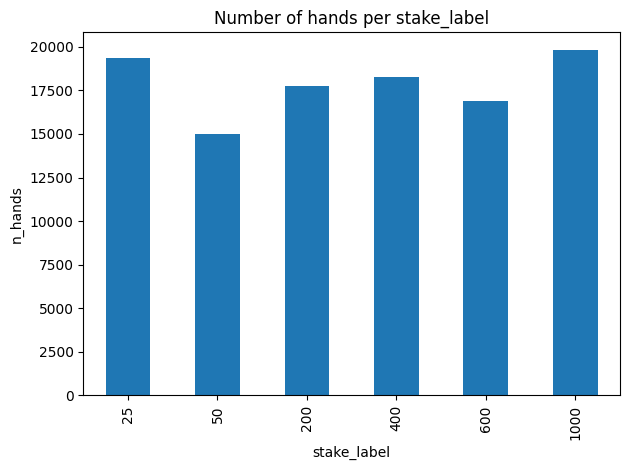

In [5]:
from IPython.display import display
import matplotlib.pyplot as plt

# ====== Overview by stake_label ======
overview_h = (hands.groupby("stake_label")
              .agg(n_hands=("hand_id", "count"),
                   n_players=("player_id", "nunique"),
                   n_tables=("table_id", "nunique"))
              .sort_index())

overview_a = (actions.groupby("stake_label")
              .agg(n_actions=("hand_id", "count"))
              .sort_index())

overview = overview_h.join(overview_a, how="left")
overview["actions_per_hand"] = overview["n_actions"] / overview["n_hands"]

display(overview)

# ====== Simple plot: hands per stake ======
plt.figure()
overview["n_hands"].plot(kind="bar")
plt.title("Number of hands per stake_label")
plt.xlabel("stake_label")
plt.ylabel("n_hands")
plt.tight_layout()
plt.show()


In [6]:
from IPython.display import display
import numpy as np

# Sécurité : start en numérique
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")

start_by_stake = (hands.groupby("stake_label")["start"]
                  .agg(
                      n_hands="count",
                      mean_start="mean",
                      median_start="median",
                      std_start="std",
                      p05=lambda s: np.nanpercentile(s, 5),
                      p25=lambda s: np.nanpercentile(s, 25),
                      p75=lambda s: np.nanpercentile(s, 75),
                      p95=lambda s: np.nanpercentile(s, 95),
                  )
                  .sort_index())

display(start_by_stake)


,n_hands,mean_start,median_start,std_start,p05,p25,p75,p95
stake_label,,,,,,,,
25,19331,17.664935,15.70,10.305135,4.45,9.600,24.90,35.675
50,15013,42.413925,39.65,25.602813,9.75,23.150,55.50,91.250
200,17755,164.831273,132.10,127.227545,36.00,74.725,211.00,408.950
400,18261,322.986337,275.45,219.552604,74.00,156.900,426.85,733.750
600,16885,475.343829,408.15,322.551793,109.50,209.000,640.05,1070.810
1000,19838,765.959772,641.75,582.359364,170.00,293.000,1049.00,1774.725


In [7]:
from IPython.display import display
import numpy as np
import pandas as pd

# Sécurité : colonnes en numérique
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")
hands["net_from_stacks"] = pd.to_numeric(hands["net_from_stacks"], errors="coerce")

# net_pct (éviter division par 0)
hands["net_pct"] = np.where(hands["start"] != 0, hands["net_from_stacks"] / hands["start"], np.nan)

# 1) Stats descriptives de net_pct par stake
netpct_by_stake = (hands.groupby("stake_label")["net_pct"]
                   .agg(
                       n_hands="count",
                       mean_netpct="mean",
                       median_netpct="median",
                       std_netpct="std",
                       p01=lambda s: np.nanpercentile(s, 1),
                       p05=lambda s: np.nanpercentile(s, 5),
                       p25=lambda s: np.nanpercentile(s, 25),
                       p75=lambda s: np.nanpercentile(s, 75),
                       p95=lambda s: np.nanpercentile(s, 95),
                       p99=lambda s: np.nanpercentile(s, 99),
                   )
                   .sort_index())

display(netpct_by_stake)

# 2) Proportions net>0 / net<0 / net=0 par stake (sur net_from_stacks)
def pct(cond):
    return float(np.mean(cond))

net_sign_by_stake = (hands.groupby("stake_label")["net_from_stacks"]
                     .apply(lambda s: pd.Series({
                         "p_net_gt_0": pct(s > 0),
                         "p_net_lt_0": pct(s < 0),
                         "p_net_eq_0": pct(s == 0),
                     }))
                     .sort_index())

display(net_sign_by_stake)


,n_hands,mean_netpct,median_netpct,std_netpct,p01,p05,p25,p75,p95,p99
stake_label,,,,,,,,,,
25,19331,0.016367,0.0,0.294322,-0.405375,-0.127808,-0.012019,0.000000,0.182226,0.930163
50,15013,0.009693,0.0,0.177541,-0.325000,-0.089740,-0.008920,0.000000,0.111111,0.557015
200,17755,0.011820,0.0,0.222263,-0.342738,-0.094830,-0.009307,0.000000,0.130302,0.752492
400,18261,0.012851,0.0,0.205093,-0.332601,-0.089385,-0.009702,0.000000,0.137500,0.746429
600,16885,0.013139,0.0,0.242786,-0.339095,-0.088879,-0.008596,0.000000,0.131930,0.711908
1000,19838,0.020300,0.0,0.383016,-0.361211,-0.099320,-0.009480,0.002101,0.150006,0.999865


stake_label            
25           p_net_eq_0    0.434018
             p_net_gt_0    0.210491
             p_net_lt_0    0.355491
50           p_net_eq_0    0.400986
             p_net_gt_0    0.247319
             p_net_lt_0    0.351695
200          p_net_eq_0    0.423824
             p_net_gt_0    0.231935
             p_net_lt_0    0.344241
400          p_net_eq_0    0.418597
             p_net_gt_0    0.230710
             p_net_lt_0    0.350693
600          p_net_eq_0    0.463370
             p_net_gt_0    0.211430
             p_net_lt_0    0.325200
1000         p_net_eq_0    0.394294
             p_net_gt_0    0.251588
             p_net_lt_0    0.354118
Name: net_from_stacks, dtype: float64

In [8]:
from IPython.display import display
import pandas as pd

# Ordre souhaité des streets
street_order = ["PREFLOP", "FLOP", "TURN", "RIVER"]

# ====== 1) Street distribution (ALL actions) ======
print("\n=== TABLE 1: Street distribution (ALL actions) — share of actions by street within each stake ===")
street_counts = (actions.groupby(["stake_label", "street"])
                 .size()
                 .reset_index(name="n_actions"))

street_counts["pct_within_stake"] = (
    street_counts["n_actions"] /
    street_counts.groupby("stake_label")["n_actions"].transform("sum")
)

street_pivot = (street_counts.pivot(index="stake_label", columns="street", values="pct_within_stake")
                .fillna(0)
                .sort_index()
                .reindex(columns=street_order))

display(street_pivot)

# ====== 2) Street distribution (HERO actions only) ======
print("\n=== TABLE 2: Street distribution (HERO actions only) — share of HERO actions by street within each stake ===")
hero_actions = actions[actions["is_hero"] == True].copy()

hero_street_counts = (hero_actions.groupby(["stake_label", "street"])
                      .size()
                      .reset_index(name="n_actions"))

hero_street_counts["pct_within_stake"] = (
    hero_street_counts["n_actions"] /
    hero_street_counts.groupby("stake_label")["n_actions"].transform("sum")
)

hero_street_pivot = (hero_street_counts.pivot(index="stake_label", columns="street", values="pct_within_stake")
                     .fillna(0)
                     .sort_index()
                     .reindex(columns=street_order))

display(hero_street_pivot)

# ====== 3) HERO action counts ======
print("\n=== TABLE 3: Total number of HERO actions per stake ===")
hero_summary = hero_actions.groupby("stake_label").size().to_frame("n_hero_actions").sort_index()
display(hero_summary)



=== TABLE 1: Street distribution (ALL actions) — share of actions by street within each stake ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,0.593474,0.182160,0.095695,0.128671
50,0.622388,0.169535,0.089549,0.118528
200,0.659288,0.152342,0.075202,0.113169
400,0.658805,0.149953,0.075356,0.115886
600,0.679574,0.142169,0.068419,0.109838
1000,0.681612,0.132731,0.064453,0.121203



=== TABLE 2: Street distribution (HERO actions only) — share of HERO actions by street within each stake ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,0.513589,0.216292,0.118994,0.151125
50,0.546289,0.199151,0.112798,0.141762
200,0.582029,0.189780,0.096326,0.131865
400,0.576133,0.190020,0.098703,0.135144
600,0.611876,0.175890,0.087155,0.125079
1000,0.616297,0.164972,0.082365,0.136366



=== TABLE 3: Total number of HERO actions per stake ===


,n_hero_actions
stake_label,
25,39775
50,27793
200,31684
400,32765
600,28478
1000,33036


In [9]:
from IPython.display import display
import pandas as pd
import numpy as np

# =========================
# 1) HERO + décisionnel
# =========================
hero = actions[actions["is_hero"] == True].copy()
hero["action_type_clean"] = hero["action_type"].fillna("MISSING_ACTION_TYPE").astype(str)

fold_set = {"fold"}
call_check_set = {"call", "check", "call_or_check"}
bet_raise_set = {"bet", "raise", "bet_or_raise"}

def bucket_action(a: str) -> str:
    if a in fold_set:
        return "fold"
    if a in call_check_set:
        return "call_or_check"
    if a in bet_raise_set:
        return "bet_or_raise"
    return "NON_DECISION"

hero["decision_bucket"] = hero["action_type_clean"].map(bucket_action)

# =========================
# 2) Garder uniquement les actions avec montant exploitable
#    - bet_or_raise: montant attendu
#    - call_or_check: garder seulement les lignes avec amount non manquant (= calls)
# =========================
hero["amount_num"] = pd.to_numeric(hero["amount"], errors="coerce")

hero_amt = hero[
    (hero["decision_bucket"] == "bet_or_raise") |
    ((hero["decision_bucket"] == "call_or_check") & hero["amount_num"].notna())
].copy()

hero_amt["amount_action"] = np.where(
    hero_amt["decision_bucket"] == "bet_or_raise",
    "bet_or_raise",
    "call"  # call_or_check avec amount => on l'interprète comme call
)

print("=== AMOUNT FILTERING SUMMARY (HERO) ===")
print("HERO actions (raw):", len(hero))
print("HERO decision actions (fold/call_or_check/bet_or_raise):", int((hero["decision_bucket"] != "NON_DECISION").sum()))
print("HERO rows kept for amount analysis:", len(hero_amt))
print("Kept breakdown:", hero_amt["amount_action"].value_counts().to_dict())

# =========================
# 3) Merge avec hands pour récupérer start et normaliser
# =========================
hands_key = hands[["stake_label", "player_id", "hand_id", "start"]].copy()
hands_key["start"] = pd.to_numeric(hands_key["start"], errors="coerce")

hero_amt = hero_amt.merge(
    hands_key,
    on=["stake_label", "player_id", "hand_id"],
    how="left",
    validate="m:1"
)

print("\nMerge success rate (start non-missing):", float(hero_amt["start"].notna().mean()))

hero_amt["amount_pct_start"] = np.where(
    hero_amt["start"].notna() & (hero_amt["start"] != 0),
    hero_amt["amount_num"] / hero_amt["start"],
    np.nan
)

# =========================
# 4) Stats par stake x street x amount_action
# =========================
def q(s, p):
    return np.nanpercentile(s, p) if len(s.dropna()) > 0 else np.nan

stats = (hero_amt
         .groupby(["stake_label", "street", "amount_action"])
         .agg(
             n=("amount_num", "count"),
             median_amount=("amount_num", "median"),
             p25_amount=("amount_num", lambda s: q(s, 25)),
             p75_amount=("amount_num", lambda s: q(s, 75)),
             p95_amount=("amount_num", lambda s: q(s, 95)),
             median_amt_pct_start=("amount_pct_start", "median"),
             p25_amt_pct_start=("amount_pct_start", lambda s: q(s, 25)),
             p75_amt_pct_start=("amount_pct_start", lambda s: q(s, 75)),
             p95_amt_pct_start=("amount_pct_start", lambda s: q(s, 95)),
         )
         .sort_index())

print("\n=== TABLE: HERO amount stats (absolute + normalized) by stake x street x action ===")
display(stats)


=== AMOUNT FILTERING SUMMARY (HERO) ===
HERO actions (raw): 193531
HERO decision actions (fold/call_or_check/bet_or_raise): 179038
HERO rows kept for amount analysis: 35216
Kept breakdown: {'bet_or_raise': 35216}

Merge success rate (start non-missing): 1.0

=== TABLE: HERO amount stats (absolute + normalized) by stake x street x action ===


n  median_amount  p25_amount  \
stake_label street  amount_action                                    
25          FLOP    bet_or_raise   2194           0.75         0.5   
            PREFLOP bet_or_raise   1934           0.75         0.5   
            RIVER   bet_or_raise    999           1.25         0.5   
            TURN    bet_or_raise   1394           1.00         0.5   
50          FLOP    bet_or_raise   1497           1.75         1.0   
            PREFLOP bet_or_raise   2231           1.50         1.5   
            RIVER   bet_or_raise    621           2.50         1.0   
            TURN    bet_or_raise    864           2.00         1.0   
200         FLOP    bet_or_raise   1531           8.00         4.0   
            PREFLOP bet_or_raise   2672           6.00         6.0   
            RIVER   bet_or_raise    604          12.00         7.0   
            TURN    bet_or_raise    898           8.00         4.0   
400         FLOP    bet_or_raise   1589          12.00         8.0   
            PREFLOP bet_or_raise   2606          12.00        12.0   
            RIVER   bet_or_raise    700          20.00        12.0   
            TURN    bet_or_raise    986          16.00         8.0   
600         FLOP    bet_or_raise   1357          24.00        12.0   
            PREFLOP bet_or_raise   2605          18.00        15.0   
            RIVER   bet_or_raise    485          36.00        18.0   
            TURN    bet_or_raise    700          24.00        12.0   
1000        FLOP    bet_or_raise   1532          40.00        20.0   
            PREFLOP bet_or_raise   3842          30.00        30.0   
            RIVER   bet_or_raise    544          62.50        30.0   
            TURN    bet_or_raise    831          40.00        30.0   

                                   p75_amount  p95_amount  \
stake_label street  amount_action                           
25          FLOP    bet_or_raise         1.25      4.0000   
            PREFLOP bet_or_raise         1.00      3.0000   
            RIVER   bet_or_raise         2.50      6.5650   
            TURN    bet_or_raise         1.50      5.0000   
50          FLOP    bet_or_raise         3.00      9.0400   
            PREFLOP bet_or_raise         2.00      6.4250   
            RIVER   bet_or_raise         5.00     17.9500   
            TURN    bet_or_raise         4.00     12.0000   
200         FLOP    bet_or_raise        12.00     38.4500   
            PREFLOP bet_or_raise         8.00     24.8125   
            RIVER   bet_or_raise        24.00     74.0000   
            TURN    bet_or_raise        18.00     60.0000   
400         FLOP    bet_or_raise        24.00     69.5000   
            PREFLOP bet_or_raise        14.00     48.0000   
            RIVER   bet_or_raise        44.00    132.5675   
            TURN    bet_or_raise        32.00    104.0000   
600         FLOP    bet_or_raise        36.00    120.0000   
            PREFLOP bet_or_raise        24.00     96.0000   
            RIVER   bet_or_raise        72.00    264.1100   
            TURN    bet_or_raise        54.00    156.1625   
1000        FLOP    bet_or_raise        70.00    280.0000   
            PREFLOP bet_or_raise        40.00    190.0000   
            RIVER   bet_or_raise       120.00    447.0000   
            TURN    bet_or_raise        90.00    300.0000   

                                   median_amt_pct_start  p25_amt_pct_start  \
stake_label street  amount_action                                            
25          FLOP    bet_or_raise               0.050505           0.026882   
            PREFLOP bet_or_raise               0.050000           0.031381   
            RIVER   bet_or_raise               0.091743           0.039165   
            TURN    bet_or_raise               0.058824           0.028777   
50          FLOP    bet_or_raise               0.048077           0.027701   
            PREFLOP bet_or_raise               0.040000           0.026870   
      

In [10]:
from IPython.display import display
import pandas as pd
import numpy as np

street_order = ["PREFLOP", "FLOP", "TURN", "RIVER"]

# ====== HERO only + decision buckets ======
hero = actions[actions["is_hero"] == True].copy()
hero["action_type_clean"] = hero["action_type"].fillna("MISSING_ACTION_TYPE").astype(str)

fold_set = {"fold"}
call_check_set = {"call", "check", "call_or_check"}
bet_raise_set = {"bet", "raise", "bet_or_raise"}

def bucket_action(a: str) -> str:
    if a in fold_set:
        return "fold"
    if a in call_check_set:
        return "call_or_check"
    if a in bet_raise_set:
        return "bet_or_raise"
    return "NON_DECISION"

hero["decision_bucket"] = hero["action_type_clean"].map(bucket_action)

hero_dec = hero[hero["decision_bucket"].isin(["fold", "call_or_check", "bet_or_raise"])].copy()

# ====== Counts by stake x street ======
counts = (hero_dec.groupby(["stake_label", "street", "decision_bucket"])
          .size()
          .unstack("decision_bucket", fill_value=0)
          .reset_index())

# Ensure missing columns exist
for col in ["fold", "call_or_check", "bet_or_raise"]:
    if col not in counts.columns:
        counts[col] = 0

counts["n_decisions"] = counts["fold"] + counts["call_or_check"] + counts["bet_or_raise"]
counts["n_non_fold"] = counts["call_or_check"] + counts["bet_or_raise"]

# ====== Rates ======
counts["BRS"] = np.where(counts["n_decisions"] > 0, counts["bet_or_raise"] / counts["n_decisions"], np.nan)
counts["BRS_NF"] = np.where(counts["n_non_fold"] > 0, counts["bet_or_raise"] / counts["n_non_fold"], np.nan)

# ====== Pivot tables (clean display) ======
def pivot_rate(colname, title):
    print(f"\n=== {title} ===")
    tmp = counts.pivot(index="stake_label", columns="street", values=colname).fillna(0).sort_index()
    tmp = tmp.reindex(columns=street_order)
    display(tmp)

def pivot_count(colname, title):
    print(f"\n=== {title} ===")
    tmp = counts.pivot(index="stake_label", columns="street", values=colname).fillna(0).sort_index()
    tmp = tmp.reindex(columns=street_order)
    display(tmp)

pivot_rate("BRS", "TABLE 1: Bet/Raise Share (BRS) — bet_or_raise / all decisions (HERO decision actions only)")
pivot_rate("BRS_NF", "TABLE 2: Bet/Raise Share Given No Fold (BRS-NF) — bet_or_raise / (call_or_check + bet_or_raise)")

pivot_count("n_decisions", "TABLE 3: Number of HERO decision actions (n_decisions) — for reliability checks")
pivot_count("n_non_fold", "TABLE 4: Number of HERO non-fold decisions (n_non_fold) — denominator of BRS-NF")



=== TABLE 1: Bet/Raise Share (BRS) — bet_or_raise / all decisions (HERO decision actions only) ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,0.094725,0.255592,0.295402,0.332114
50,0.146999,0.270705,0.276038,0.299855
200,0.144950,0.254912,0.294523,0.318902
400,0.138103,0.255425,0.305263,0.344488
600,0.149506,0.270966,0.282031,0.315345
1000,0.188731,0.281307,0.305402,0.321893



=== TABLE 2: Bet/Raise Share Given No Fold (BRS-NF) — bet_or_raise / (call_or_check + bet_or_raise) ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,0.215367,0.321183,0.346335,0.400240
50,0.356219,0.329011,0.320713,0.361047
200,0.367740,0.316649,0.340280,0.373994
400,0.355186,0.315466,0.354804,0.403226
600,0.423440,0.338151,0.329722,0.375969
1000,0.503275,0.343729,0.351226,0.377516



=== TABLE 3: Number of HERO decision actions (n_decisions) — for reliability checks ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,20417,8584,4719,3008
50,15177,5530,3130,2071
200,18434,6006,3049,1894
400,18870,6221,3230,2032
600,17424,5008,2482,1538
1000,20357,5446,2721,1690



=== TABLE 4: Number of HERO non-fold decisions (n_non_fold) — denominator of BRS-NF ===


street,PREFLOP,FLOP,TURN,RIVER
stake_label,,,,
25,8980,6831,4025,2496
50,6263,4550,2694,1720
200,7266,4835,2639,1615
400,7337,5037,2779,1736
600,6152,4013,2123,1290
1000,7634,4457,2366,1441


In [11]:
from IPython.display import display
import pandas as pd
import numpy as np

# ====== 0) Ensure net_pct and ts_dt exist ======
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")
hands["net_from_stacks"] = pd.to_numeric(hands["net_from_stacks"], errors="coerce")

hands["net_pct"] = np.where(
    hands["start"].notna() & (hands["start"] != 0),
    hands["net_from_stacks"] / hands["start"],
    np.nan
)

hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)

# Keep only rows we can order and evaluate
hands_ord = hands.dropna(subset=["player_id", "stake_label", "hand_id", "ts_dt", "net_pct"]).copy()

# ====== 1) Build a stable sequence index per (player, stake) ======
hands_ord = hands_ord.sort_values(["player_id", "stake_label", "ts_dt", "hand_id"])
hands_ord["seq_no"] = hands_ord.groupby(["player_id", "stake_label"]).cumcount()

print("Hands usable for event building:", len(hands_ord))

# ====== 2) Create events for several candidate thresholds ======
thresholds = [-0.10, -0.20, -0.30]  # change later once you choose
events_list = []

for t in thresholds:
    ev = hands_ord[hands_ord["net_pct"] <= t].copy()
    ev["loss_threshold"] = t
    events_list.append(ev[[
        "loss_threshold", "stake_label", "player_id",
        "hand_id", "hand_uid", "ts_dt", "seq_no",
        "start", "net_from_stacks", "net_pct"
    ]])

events = pd.concat(events_list, ignore_index=True) if len(events_list) > 0 else pd.DataFrame()

print("Total events across all thresholds:", len(events))

# ====== 3) Summary: how many events per threshold (overall + by stake) ======
print("\n=== TABLE A: Event counts by threshold (overall) ===")
display(events.groupby("loss_threshold").size().to_frame("n_events"))

print("\n=== TABLE B: Event counts by threshold x stake ===")
display(events.groupby(["loss_threshold", "stake_label"]).size().unstack("stake_label", fill_value=0))

# ====== 4) Summary: events per player (are events too concentrated?) ======
ev_per_player = (events.groupby(["loss_threshold", "player_id"])
                 .size()
                 .reset_index(name="n_events_player"))

print("\n=== TABLE C: Events per player — descriptive stats (by threshold) ===")
summary = (ev_per_player.groupby("loss_threshold")["n_events_player"]
           .agg(["count", "mean", "median", "max"])
           .rename(columns={"count":"n_players_with_>=1_event"}))
display(summary)

print("\n=== TABLE D: Top 10 players with most events (per threshold) ===")
top10 = (ev_per_player.sort_values(["loss_threshold", "n_events_player"], ascending=[True, False])
         .groupby("loss_threshold")
         .head(10))
display(top10)


Hands usable for event building: 107083
Total events across all thresholds: 9236

=== TABLE A: Event counts by threshold (overall) ===


,n_events
loss_threshold,
-0.3,1434
-0.2,2511
-0.1,5291



=== TABLE B: Event counts by threshold x stake ===


stake_label,25,50,200,400,600,1000
loss_threshold,,,,,,
-0.3,330,167,230,218,208,281
-0.2,589,301,385,397,362,477
-0.1,1217,674,844,818,753,985



=== TABLE C: Events per player — descriptive stats (by threshold) ===


,n_players_with_>=1_event,mean,median,max
loss_threshold,,,,
-0.3,648,2.212963,2.0,18
-0.2,836,3.003589,2.0,39
-0.1,1050,5.039048,3.0,59



=== TABLE D: Top 10 players with most events (per threshold) ===


,loss_threshold,player_id,n_events_player
434,-0.3,e7LJLRVa90gX_dc235c8b1c,18
428,-0.3,dt8ZgHwPbhhm_0d08203ebb,13
251,-0.3,MVLHRFn+Owu1_3785dfc24b,12
461,-0.3,hiwfQaCUizSV_816404d834,12
74,-0.3,6i2gxQrut57G_0ff2cf715c,10
49,-0.3,3qjDlcZYDqiU_ac89f13710,9
462,-0.3,hojQqzlwLR6V_f717a68fdf,9
130,-0.3,ANSS572k4jaS_73c90cf13f,8
166,-0.3,EQEvt12l5FG4_0ae12a949d,8
324,-0.3,TPKsP+34Ioqq_c34bb41484,8


In [12]:
from IPython.display import display
import numpy as np
import pandas as pd

# --- Make sure numeric ---
hands["stake_label"] = pd.to_numeric(hands["stake_label"], errors="coerce")
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")
hands["net_from_stacks"] = pd.to_numeric(hands["net_from_stacks"], errors="coerce")

# --- Candidate Big Blind value derived from stake_label ---
hands["bb_guess"] = hands["stake_label"] / 100.0

# Avoid division issues
valid = hands["bb_guess"].notna() & (hands["bb_guess"] > 0) & hands["start"].notna() & hands["net_from_stacks"].notna()

hands.loc[valid, "start_bb"] = hands.loc[valid, "start"] / hands.loc[valid, "bb_guess"]
hands.loc[valid, "net_bb"]   = hands.loc[valid, "net_from_stacks"] / hands.loc[valid, "bb_guess"]

# --- Sanity check: start_bb distribution should be broadly comparable across stakes ---
summary_bb = (hands.loc[valid]
              .groupby("stake_label")["start_bb"]
              .agg(
                  n="count",
                  mean="mean",
                  median="median",
                  p25=lambda s: np.percentile(s, 25),
                  p75=lambda s: np.percentile(s, 75),
                  p95=lambda s: np.percentile(s, 95),
              )
              .sort_index())

print("=== TABLE: start_bb sanity check (if bb_guess is correct, magnitudes should look comparable across stakes) ===")
display(summary_bb)


=== TABLE: start_bb sanity check (if bb_guess is correct, magnitudes should look comparable across stakes) ===


,n,mean,median,p25,p75,p95
stake_label,,,,,,
25,19331,70.659738,62.8000,38.400000,99.6000,142.700000
50,15013,84.827849,79.3000,46.300000,111.0000,182.500000
200,17755,82.415636,66.0500,37.362500,105.5000,204.475000
400,18261,80.746584,68.8625,39.225000,106.7125,183.437500
600,16885,79.223971,68.0250,34.833333,106.6750,178.468333
1000,19838,76.595977,64.1750,29.300000,104.9000,177.472500


In [13]:
from IPython.display import display
import numpy as np
import pandas as pd

# Ensure required columns exist
hands["stake_label"] = pd.to_numeric(hands["stake_label"], errors="coerce")
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")
hands["net_from_stacks"] = pd.to_numeric(hands["net_from_stacks"], errors="coerce")

hands["bb"] = hands["stake_label"] / 100.0

valid = (
    hands["bb"].notna() & (hands["bb"] > 0) &
    hands["start"].notna() & (hands["start"] != 0) &
    hands["net_from_stacks"].notna()
)

hands.loc[valid, "start_bb"] = hands.loc[valid, "start"] / hands.loc[valid, "bb"]
hands.loc[valid, "net_bb"]   = hands.loc[valid, "net_from_stacks"] / hands.loc[valid, "bb"]
hands.loc[valid, "net_pct"]  = hands.loc[valid, "net_from_stacks"] / hands.loc[valid, "start"]

hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)

base = hands.dropna(subset=["player_id","stake_label","hand_id","ts_dt","start_bb","net_bb","net_pct"]).copy()
base = base.sort_values(["player_id","stake_label","ts_dt","hand_id"])
base["seq_no"] = base.groupby(["player_id","stake_label"]).cumcount()

print("Hands usable (combined-rule base):", len(base))

# ====== Candidate rules ======
rules = [
    {"rule_name": "pct20 + net_bb<=-10 + start_bb>=40", "net_pct_max": -0.20, "net_bb_max": -10, "start_bb_min": 40},
    {"rule_name": "pct20 + net_bb<=-8  + start_bb>=30", "net_pct_max": -0.20, "net_bb_max": -8,  "start_bb_min": 30},
    {"rule_name": "pct20 + net_bb<=-12 + start_bb>=50", "net_pct_max": -0.20, "net_bb_max": -12, "start_bb_min": 50},
]

events_list = []
for r in rules:
    ev = base[
        (base["net_pct"] <= r["net_pct_max"]) &
        (base["net_bb"]  <= r["net_bb_max"]) &
        (base["start_bb"] >= r["start_bb_min"])
    ].copy()
    ev["rule_name"] = r["rule_name"]
    events_list.append(ev[[
        "rule_name","stake_label","player_id","hand_id","hand_uid","ts_dt","seq_no",
        "start","start_bb","net_from_stacks","net_bb","net_pct"
    ]])

events_combined = pd.concat(events_list, ignore_index=True)

print("\n=== TABLE A: Combined-rule event counts (overall) ===")
display(events_combined.groupby("rule_name").size().to_frame("n_events"))

print("\n=== TABLE B: Combined-rule event counts by stake ===")
display(events_combined.groupby(["rule_name","stake_label"]).size().unstack("stake_label", fill_value=0))

evpp = (events_combined.groupby(["rule_name","player_id"]).size().reset_index(name="n_events_player"))
print("\n=== TABLE C: Combined-rule events per player (descriptive stats) ===")
display(evpp.groupby("rule_name")["n_events_player"].agg(["count","mean","median","max"]).rename(columns={"count":"n_players_with_>=1_event"}))


Hands usable (combined-rule base): 107083

=== TABLE A: Combined-rule event counts (overall) ===


,n_events
rule_name,
pct20 + net_bb<=-10 + start_bb>=40,1276
pct20 + net_bb<=-12 + start_bb>=50,1012
pct20 + net_bb<=-8 + start_bb>=30,1619



=== TABLE B: Combined-rule event counts by stake ===


stake_label,25,50,200,400,600,1000
rule_name,,,,,,
pct20 + net_bb<=-10 + start_bb>=40,291,172,204,205,167,237
pct20 + net_bb<=-12 + start_bb>=50,226,142,159,164,132,189
pct20 + net_bb<=-8 + start_bb>=30,361,202,248,266,241,301



=== TABLE C: Combined-rule events per player (descriptive stats) ===


,n_players_with_>=1_event,mean,median,max
rule_name,,,,
pct20 + net_bb<=-10 + start_bb>=40,621,2.054750,1.0,13
pct20 + net_bb<=-12 + start_bb>=50,527,1.920304,1.0,10
pct20 + net_bb<=-8 + start_bb>=30,719,2.251739,2.0,16


In [14]:
from IPython.display import display
import numpy as np
import pandas as pd

COOLDOWN = 20

# ====== Ensure required columns exist ======
hands["stake_label"] = pd.to_numeric(hands["stake_label"], errors="coerce")
hands["start"] = pd.to_numeric(hands["start"], errors="coerce")
hands["net_from_stacks"] = pd.to_numeric(hands["net_from_stacks"], errors="coerce")
hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)

hands["bb"] = hands["stake_label"] / 100.0

valid = (
    hands["bb"].notna() & (hands["bb"] > 0) &
    hands["start"].notna() & (hands["start"] != 0) &
    hands["net_from_stacks"].notna() &
    hands["ts_dt"].notna() &
    hands["player_id"].notna() &
    hands["hand_id"].notna()
)

hands.loc[valid, "start_bb"] = hands.loc[valid, "start"] / hands.loc[valid, "bb"]
hands.loc[valid, "net_bb"]   = hands.loc[valid, "net_from_stacks"] / hands.loc[valid, "bb"]
hands.loc[valid, "net_pct"]  = hands.loc[valid, "net_from_stacks"] / hands.loc[valid, "start"]

base = hands.loc[valid].copy()
base = base.sort_values(["player_id", "stake_label", "ts_dt", "hand_id"])
base["seq_no"] = base.groupby(["player_id", "stake_label"]).cumcount()

print("Hands usable (multi-len base):", len(base))

g = base.groupby(["player_id", "stake_label"], sort=False)

# shifts for next hands (t+1, t+2)
base["net1"]   = base["net_from_stacks"]
base["net2"]   = g["net_from_stacks"].shift(-1)
base["net3"]   = g["net_from_stacks"].shift(-2)

base["bb1"]    = base["net_bb"]
base["bb2"]    = g["net_bb"].shift(-1)
base["bb3"]    = g["net_bb"].shift(-2)

base["hand2_id"] = g["hand_id"].shift(-1)
base["hand3_id"] = g["hand_id"].shift(-2)

# sums
base["sum_net_1"] = base["net1"]
base["sum_net_2"] = base["net1"] + base["net2"]
base["sum_net_3"] = base["net1"] + base["net2"] + base["net3"]

base["sum_bb_1"]  = base["bb1"]
base["sum_bb_2"]  = base["bb1"] + base["bb2"]
base["sum_bb_3"]  = base["bb1"] + base["bb2"] + base["bb3"]

# ratios wrt start of FIRST hand in the sequence
base["sum_pct_1_wrt_start1"] = base["sum_net_1"] / base["start"]
base["sum_pct_2_wrt_start1"] = base["sum_net_2"] / base["start"]
base["sum_pct_3_wrt_start1"] = base["sum_net_3"] / base["start"]

# availability
has2 = base["net2"].notna()
has3 = base["net3"].notna()

# IMPORTANT: "pertes d'affilée" => each hand in the window must be a loss
loss1 = base["net1"] < 0
loss2 = has2 & (base["net2"] < 0)
loss3 = has3 & (base["net3"] < 0)

# your thresholds
START_BB_MIN = 40
PCT_MAX      = -0.20
BB_MAX       = -10

# triggers by length
trig1 = (base["start_bb"] >= START_BB_MIN) & loss1 & (base["sum_pct_1_wrt_start1"] <= PCT_MAX) & (base["sum_bb_1"] <= BB_MAX)

trig2 = (base["start_bb"] >= START_BB_MIN) & loss1 & loss2 & (base["sum_pct_2_wrt_start1"] <= PCT_MAX) & (base["sum_bb_2"] <= BB_MAX)

trig3 = (base["start_bb"] >= START_BB_MIN) & loss1 & loss2 & loss3 & (base["sum_pct_3_wrt_start1"] <= PCT_MAX) & (base["sum_bb_3"] <= BB_MAX)

# choose the shortest length that triggers (1 > 2 > 3)
base["event_len"] = np.select([trig1, trig2, trig3], [1, 2, 3], default=np.nan)

cand = base[base["event_len"].notna()].copy()
cand["event_len"] = cand["event_len"].astype(int)

print("Candidate events (before cooldown):", len(cand))
print("Breakdown by event_len (before cooldown):")
display(cand["event_len"].value_counts().sort_index().to_frame("n_events_before_cd"))

events = cand[[
    "stake_label","player_id",
    "hand_id","hand_uid","ts_dt","seq_no",
    "start","start_bb",
    "event_len",
    "sum_net_1","sum_net_2","sum_net_3",
    "sum_bb_1","sum_bb_2","sum_bb_3",
    "sum_pct_1_wrt_start1","sum_pct_2_wrt_start1","sum_pct_3_wrt_start1",
    "hand2_id","hand3_id"
]].copy()

events = events.rename(columns={
    "hand_id": "event_hand_id",
    "hand_uid": "event_hand_uid",
    "ts_dt": "event_ts_dt",
    "seq_no": "event_seq_no",
    "start": "event_start",
    "start_bb": "event_start_bb",
})

# keep the sums corresponding to the chosen length (for clean downstream use)
events["event_sum_net"] = np.where(events["event_len"] == 1, events["sum_net_1"],
                         np.where(events["event_len"] == 2, events["sum_net_2"], events["sum_net_3"]))
events["event_sum_bb"]  = np.where(events["event_len"] == 1, events["sum_bb_1"],
                         np.where(events["event_len"] == 2, events["sum_bb_2"], events["sum_bb_3"]))
events["event_sum_pct_wrt_start1"] = np.where(events["event_len"] == 1, events["sum_pct_1_wrt_start1"],
                                     np.where(events["event_len"] == 2, events["sum_pct_2_wrt_start1"], events["sum_pct_3_wrt_start1"]))

# ====== Apply cooldown (20 mains) within each (player, stake) ======
def apply_cooldown(df, cooldown):
    df = df.sort_values("event_seq_no")
    keep = []
    last = -10**18
    for idx, s in zip(df.index, df["event_seq_no"].values):
        if s >= last + cooldown + 1:
            keep.append(idx)
            last = s
    return df.loc[keep]

events_cd = (events.groupby(["player_id","stake_label"], group_keys=False)
             .apply(apply_cooldown, cooldown=COOLDOWN)
             .reset_index(drop=True))

print("Events kept (after cooldown):", len(events_cd))
print("Breakdown by event_len (after cooldown):")
display(events_cd["event_len"].value_counts().sort_index().to_frame("n_events_after_cd"))

print("\n=== TABLE A: Events kept (after cooldown) by stake x event_len ===")
display(events_cd.groupby(["stake_label","event_len"]).size().unstack("event_len", fill_value=0).sort_index())

evpp = events_cd.groupby("player_id").size().reset_index(name="n_events_player")
print("\n=== TABLE B: Events per player (after cooldown) ===")
display(evpp["n_events_player"].agg(["count","mean","median","max"]).to_frame().T.rename(columns={"count":"n_players_with_>=1_event"}))

print("\nSample events:")
display(events_cd.head(10))


Hands usable (multi-len base): 107083
Candidate events (before cooldown): 2258
Breakdown by event_len (before cooldown):


,n_events_before_cd
event_len,
1,1276
2,663
3,319


Events kept (after cooldown): 1141
Breakdown by event_len (after cooldown):


/tmp/ipython-input-2269705715.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_cooldown, cooldown=COOLDOWN)


,n_events_after_cd
event_len,
1,616
2,309
3,216



=== TABLE A: Events kept (after cooldown) by stake x event_len ===


event_len,1,2,3
stake_label,,,
25,126,67,60
50,80,52,35
200,98,40,34
400,94,69,32
600,92,35,21
1000,126,46,34



=== TABLE B: Events per player (after cooldown) ===


,n_players_with_>=1_event,mean,median,max
n_events_player,684.0,1.668129,1.0,9.0



Sample events:


,stake_label,player_id,event_hand_id,event_hand_uid,event_ts_dt,event_seq_no,event_start,event_start_bb,event_len,sum_net_1,...,sum_bb_2,sum_bb_3,sum_pct_1_wrt_start1,sum_pct_2_wrt_start1,sum_pct_3_wrt_start1,hand2_id,hand3_id,event_sum_net,event_sum_bb,event_sum_pct_wrt_start1
0,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.500000,2,-0.50,...,-26.00,-26.00,-0.016260,-0.422764,-0.422764,6.005251e+10,6.005261e+10,-13.00,-26.00,-0.422764
1,50,+1ZZr79prGVk_795d0be6da,60053637410,6.005364e+10,2009-07-02 16:45:54+00:00,26,28.75,57.500000,2,-0.50,...,-16.00,-16.50,-0.017391,-0.278261,-0.286957,6.005369e+10,6.005380e+10,-8.00,-16.00,-0.278261
2,200,+I3nAfirMvrv_109f1486a0,60811591690,6.081159e+10,2009-07-13 05:27:18+00:00,86,151.00,75.500000,1,-41.30,...,-20.65,-20.65,-0.273510,-0.273510,-0.273510,6.081193e+10,6.081196e+10,-41.30,-20.65,-0.273510
3,200,+I3nAfirMvrv_109f1486a0,60813568922,6.081357e+10,2009-07-13 06:31:20+00:00,163,85.70,42.850000,1,-22.00,...,-11.00,-10.50,-0.256709,-0.256709,-0.245041,6.081360e+10,6.081361e+10,-22.00,-11.00,-0.256709
4,600,+I3nAfirMvrv_109f1486a0,60841787282,6.084179e+10,2009-07-13 15:20:10+00:00,57,426.50,71.083333,3,-6.00,...,-11.00,-18.00,-0.014068,-0.154748,-0.253224,6.084186e+10,6.084192e+10,-108.00,-18.00,-0.253224
5,1000,+bMb1umDJpJN_9a64482661,59978170252,5.997817e+10,2009-07-01 15:39:45+00:00,23,729.00,72.900000,1,-185.00,...,-18.50,-17.00,-0.253772,-0.253772,-0.233196,5.997822e+10,5.997826e+10,-185.00,-18.50,-0.253772
6,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,6.019076e+10,2009-07-04 16:07:05+00:00,58,30.80,123.200000,1,-8.35,...,-34.40,-35.40,-0.271104,-0.279221,-0.287338,6.019085e+10,6.019090e+10,-8.35,-33.40,-0.271104
7,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,6.023403e+10,2009-07-05 09:39:30+00:00,89,30.50,122.000000,3,-0.25,...,-8.00,-34.00,-0.008197,-0.065574,-0.278689,6.023405e+10,6.023409e+10,-8.50,-34.00,-0.278689
8,25,+dHwJza6cu+q_a5ac9a4a30,60299272870,6.029927e+10,2009-07-06 06:48:26+00:00,119,23.10,92.400000,2,-0.25,...,-29.20,-29.20,-0.010823,-0.316017,-0.316017,6.029929e+10,6.029931e+10,-7.30,-29.20,-0.316017
9,25,+dHwJza6cu+q_a5ac9a4a30,60300200508,6.030020e+10,2009-07-06 07:16:36+00:00,153,12.00,48.000000,3,-1.75,...,-8.00,-11.00,-0.145833,-0.166667,-0.229167,6.030023e+10,6.030025e+10,-2.75,-11.00,-0.229167


In [15]:
from IPython.display import display
import numpy as np
import pandas as pd

K = 20  # number of hands AFTER the end of the event episode

# Use events after cooldown
events_final = events_cd.copy()

# Minimal base (hands timeline with seq_no)
base2 = base[[
    "stake_label","player_id","seq_no","hand_id","hand_uid","ts_dt",
    "start","start_bb","net_from_stacks","net_bb","net_pct",
    "hand_index_in_file"
]].copy()

print("Number of events (after cooldown):", len(events_final))

# Define end of episode (event_len=1 -> end=event_seq_no; event_len=3 -> end=event_seq_no+2)
events_final["episode_end_seq_no"] = events_final["event_seq_no"] + (events_final["event_len"] - 1)

# Offsets 1..K after the EPISODE END
offsets = pd.DataFrame({"delta_after": np.arange(1, K+1, dtype=int)})

# Cross join events x offsets
ev_x = events_final.merge(offsets, how="cross")
ev_x["target_seq_no"] = ev_x["episode_end_seq_no"] + ev_x["delta_after"]

# Join to get the post-episode hands
post_after = ev_x.merge(
    base2.rename(columns={
        "seq_no": "target_seq_no",
        "hand_id": "post_hand_id",
        "hand_uid": "post_hand_uid",
        "ts_dt": "post_ts_dt",
        "start": "post_start",
        "start_bb": "post_start_bb",
        "net_from_stacks": "post_net_from_stacks",
        "net_bb": "post_net_bb",
        "net_pct": "post_net_pct",
        "hand_index_in_file": "post_hand_index_in_file"
    }),
    on=["stake_label","player_id","target_seq_no"],
    how="left",
    validate="many_to_one"
)

# Keep only existing post hands
post_after = post_after.dropna(subset=["post_hand_id"]).copy()

print("Post-episode rows kept:", len(post_after))

# Coverage: how many unique events still have a hand at each delta_after
coverage_after = (post_after.groupby("delta_after")["event_hand_id"]
                  .nunique()
                  .to_frame("n_unique_events_with_post_hand")
                  .reset_index()
                  .sort_values("delta_after"))

print("\n=== TABLE: Coverage by delta_after (unique events that still have a hand at t_after+delta) ===")
display(coverage_after)

# Events with full K post-episode hands
max_delta_after = (post_after.groupby(["stake_label","player_id","event_hand_id"])["delta_after"]
                   .max()
                   .reset_index(name="max_delta_after"))

n_events_with_any = max_delta_after.shape[0]
n_full = int((max_delta_after["max_delta_after"] == K).sum())

print(f"\nEvents with >=1 post-episode hand: {n_events_with_any} / {len(events_final)}")
print(f"Events with full {K} post-episode hands: {n_full} / {n_events_with_any}")

print("\npost_after sample:")
display(post_after.head(5))


Number of events (after cooldown): 1141
Post-episode rows kept: 18378

=== TABLE: Coverage by delta_after (unique events that still have a hand at t_after+delta) ===


,delta_after,n_unique_events_with_post_hand
0,1,1102
1,2,1071
2,3,1046
3,4,1022
4,5,1001
5,6,981
6,7,959
7,8,947
8,9,934
9,10,919



Events with >=1 post-episode hand: 1102 / 1141
Events with full 20 post-episode hands: 786 / 1102

post_after sample:


,stake_label,player_id,event_hand_id,event_hand_uid,event_ts_dt,event_seq_no,event_start,event_start_bb,event_len,sum_net_1,...,target_seq_no,post_hand_id,post_hand_uid,post_ts_dt,post_start,post_start_bb,post_net_from_stacks,post_net_bb,post_net_pct,post_hand_index_in_file
0,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.5,2,-0.5,...,5,6.005261e+10,6.005261e+10,2009-07-02 16:32:10+00:00,17.75,35.5,0.00,0.0,0.000000,5.0
1,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.5,2,-0.5,...,6,6.005264e+10,6.005264e+10,2009-07-02 16:32:35+00:00,17.75,35.5,-3.50,-7.0,-0.197183,6.0
2,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.5,2,-0.5,...,7,6.005274e+10,6.005274e+10,2009-07-02 16:33:54+00:00,14.25,28.5,15.25,30.5,1.070175,7.0
3,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.5,2,-0.5,...,8,6.005278e+10,6.005278e+10,2009-07-02 16:34:28+00:00,29.50,59.0,0.00,0.0,0.000000,8.0
4,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,30.75,61.5,2,-0.5,...,9,6.005284e+10,6.005284e+10,2009-07-02 16:35:10+00:00,29.50,59.0,0.25,0.5,0.008475,9.0


In [16]:
from IPython.display import display
import pandas as pd
import numpy as np

# ====== 1) Keys from post_after (event x delta) ======
pa = post_after[["stake_label","player_id","event_hand_id","delta_after","post_hand_id"]].copy()

pa["stake_label"]  = pd.to_numeric(pa["stake_label"], errors="coerce")
pa["post_hand_id"] = pd.to_numeric(pa["post_hand_id"], errors="coerce")

pa = pa.dropna(subset=["stake_label","player_id","event_hand_id","delta_after","post_hand_id"]).copy()
pa["stake_label"]  = pa["stake_label"].astype("int64")
pa["post_hand_id"] = pa["post_hand_id"].astype("int64")
pa["delta_after"]  = pa["delta_after"].astype("int64")

# One row per (event, delta_after) -> that's our real analysis unit
pa_keys = pa.drop_duplicates(subset=["stake_label","player_id","event_hand_id","delta_after","post_hand_id"]).copy()

print("Rows (event x delta_after) in pa_keys:", len(pa_keys))
print("Unique events represented:", pa_keys["event_hand_id"].nunique())

# Why previous validate failed: same post_hand can appear for multiple events
overlap = (pa_keys.groupby(["stake_label","player_id","post_hand_id"])["event_hand_id"]
           .nunique()
           .reset_index(name="n_events_for_same_post_hand"))

n_overlap_post_hands = int((overlap["n_events_for_same_post_hand"] > 1).sum())
print("\n=== OVERLAP CHECK ===")
print("Unique post hands:", overlap.shape[0])
print("Post hands used by >1 event:", n_overlap_post_hands)

# ====== 2) HERO decision actions only ======
a = actions.copy()

a["stake_label"] = pd.to_numeric(a["stake_label"], errors="coerce")
a["hand_id"]     = pd.to_numeric(a["hand_id"], errors="coerce")
a = a.dropna(subset=["stake_label","player_id","hand_id","is_hero","action_type"]).copy()

a["stake_label"] = a["stake_label"].astype("int64")
a["hand_id"]     = a["hand_id"].astype("int64")

a = a[a["is_hero"] == True].copy()

a["action_type_clean"] = a["action_type"].astype(str).str.strip().str.lower()

def bucketize(s: str):
    if s.startswith("fold"):
        return "fold"
    if s.startswith("call") or s.startswith("check") or "call" in s or "check" in s:
        return "call_or_check"
    if s.startswith("bet") or s.startswith("raise") or "bet" in s or "raise" in s:
        return "bet_or_raise"
    return None

a["decision_bucket"] = a["action_type_clean"].map(bucketize)
a_dec = a[a["decision_bucket"].notna()].copy()

print("\n=== ACTION FILTERING (HERO) ===")
print("HERO decision actions kept:", len(a_dec))
print("Decision buckets counts:")
display(a_dec["decision_bucket"].value_counts().to_frame("n"))

# ====== 3) Join (many-to-many is expected because post hands can map to multiple events) ======
pa_actions = pa_keys.merge(
    a_dec[["stake_label","player_id","hand_id","street","action_no","decision_bucket","amount","raw_action"]],
    left_on=["stake_label","player_id","post_hand_id"],
    right_on=["stake_label","player_id","hand_id"],
    how="left",
    validate="many_to_many"
)

# ====== 4) Join sanity checks ======
# A) match rate at (event, delta_after) level
tmp = pa_actions.copy()
tmp["has_action"] = tmp["action_no"].notna()

matched_event_delta = (tmp.groupby(["stake_label","player_id","event_hand_id","delta_after"])["has_action"]
                       .any()
                       .reset_index(name="has_action_any"))

match_rate_event_delta = matched_event_delta["has_action_any"].mean()

# B) match rate at unique post-hand level (optional)
matched_post_hand = (tmp.groupby(["stake_label","player_id","post_hand_id"])["has_action"]
                     .any()
                     .reset_index(name="has_action_any"))
match_rate_post_hand = matched_post_hand["has_action_any"].mean()

print("\n=== JOIN SANITY CHECK ===")
print("Event×delta rows:", len(pa_keys))
print("Match rate (event×delta has >=1 HERO decision action):", round(float(match_rate_event_delta), 4))
print("Match rate (unique post_hand has >=1 HERO decision action):", round(float(match_rate_post_hand), 4))

# ====== 5) Coverage by delta_after (events with >=1 HERO decision action) ======
coverage_actions = (matched_event_delta[matched_event_delta["has_action_any"]]
                    .groupby("delta_after")["event_hand_id"]
                    .nunique()
                    .to_frame("n_unique_events_with_hero_decision_action")
                    .reset_index()
                    .sort_values("delta_after"))

print("\n=== TABLE A: Coverage by delta_after (events with >=1 HERO decision action) ===")
display(coverage_actions)

# ====== 6) HERO decision actions per post-hand (by delta_after) ======
actions_per_event_delta = (tmp[tmp["has_action"]]
                           .groupby(["stake_label","player_id","event_hand_id","delta_after"])
                           .size()
                           .reset_index(name="n_hero_decisions_in_post_hand"))

avg_actions_by_delta = (actions_per_event_delta.groupby("delta_after")["n_hero_decisions_in_post_hand"]
                        .agg(["count","mean","median"])
                        .reset_index()
                        .rename(columns={"count":"n_event_delta_with_actions"}))

print("\n=== TABLE B: HERO decision actions per (event×delta) (by delta_after) ===")
display(avg_actions_by_delta)

print("\npa_actions sample:")
display(pa_actions.head(10))


Rows (event x delta_after) in pa_keys: 18378
Unique events represented: 1102

=== OVERLAP CHECK ===
Unique post hands: 18376
Post hands used by >1 event: 2

=== ACTION FILTERING (HERO) ===
HERO decision actions kept: 179038
Decision buckets counts:


,n
decision_bucket,
fold,78759
call_or_check,65063
bet_or_raise,35216



=== JOIN SANITY CHECK ===
Event×delta rows: 18378
Match rate (event×delta has >=1 HERO decision action): 0.967
Match rate (unique post_hand has >=1 HERO decision action): 0.967

=== TABLE A: Coverage by delta_after (events with >=1 HERO decision action) ===


,delta_after,n_unique_events_with_hero_decision_action
0,1,1076
1,2,1034
2,3,1018
3,4,975
4,5,967
5,6,944
6,7,930
7,8,919
8,9,909
9,10,890



=== TABLE B: HERO decision actions per (event×delta) (by delta_after) ===


,delta_after,n_event_delta_with_actions,mean,median
0,1,1076,2.037175,1.0
1,2,1034,1.950677,1.0
2,3,1018,1.971513,1.0
3,4,975,1.987692,1.0
4,5,967,1.924509,1.0
5,6,944,1.962924,1.0
6,7,930,1.948387,1.0
7,8,919,2.004353,1.0
8,9,909,1.886689,1.0
9,10,890,1.892135,1.0



pa_actions sample:


,stake_label,player_id,event_hand_id,delta_after,post_hand_id,hand_id,street,action_no,decision_bucket,amount,raw_action
0,50,+1ZZr79prGVk_795d0be6da,60052474026,1,60052611442,6.005261e+10,PREFLOP,4.0,fold,0.0,fold
1,50,+1ZZr79prGVk_795d0be6da,60052474026,2,60052642330,6.005264e+10,PREFLOP,3.0,call_or_check,NaN,call/check
2,50,+1ZZr79prGVk_795d0be6da,60052474026,2,60052642330,6.005264e+10,FLOP,8.0,call_or_check,NaN,call/check
3,50,+1ZZr79prGVk_795d0be6da,60052474026,2,60052642330,6.005264e+10,TURN,10.0,call_or_check,NaN,call/check
4,50,+1ZZr79prGVk_795d0be6da,60052474026,2,60052642330,6.005264e+10,RIVER,12.0,bet_or_raise,2.0,bet/raise 2
5,50,+1ZZr79prGVk_795d0be6da,60052474026,3,60052740254,6.005274e+10,PREFLOP,2.0,call_or_check,NaN,call/check
6,50,+1ZZr79prGVk_795d0be6da,60052474026,3,60052740254,6.005274e+10,PREFLOP,7.0,fold,0.0,fold
7,50,+1ZZr79prGVk_795d0be6da,60052474026,4,60052782462,6.005278e+10,PREFLOP,1.0,fold,0.0,fold
8,50,+1ZZr79prGVk_795d0be6da,60052474026,5,60052835182,NaN,NaN,NaN,NaN,NaN,NaN
9,50,+1ZZr79prGVk_795d0be6da,60052474026,6,60052857680,6.005286e+10,PREFLOP,5.0,fold,0.0,fold


In [17]:
# =========================
# BLOCK: PRE-episode window (delta_before = 1..20)
# =========================

PRE_WINDOW = 20

# --- Safety checks ---
assert "hands" in globals(), "❌ 'hands' n'existe pas en mémoire. Re-run le bloc de load/clean."
assert "events_cd" in globals(), "❌ 'events_cd' n'existe pas en mémoire. Re-run le bloc de construction des events (after cooldown)."

# --- Ensure datetime for hands ---
if "ts_dt" not in hands.columns:
    hands = hands.copy()
    hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)

# --- Build an ordered hands index: seq_no within each (stake_label, player_id) ---
# Use ts_dt + hand_index_in_file as tie-breaker for stability
needed_cols = ["stake_label","player_id","hand_id","hand_uid","ts_dt","hand_index_in_file","start","net_from_stacks"]
missing = [c for c in needed_cols if c not in hands.columns]
assert len(missing) == 0, f"❌ Missing columns in hands: {missing}"

hands_ord = hands[needed_cols].copy()
hands_ord = hands_ord.sort_values(["stake_label","player_id","ts_dt","hand_index_in_file"], kind="mergesort")
hands_ord["seq_no"] = hands_ord.groupby(["stake_label","player_id"]).cumcount() + 1

# --- Sanity check: do event_hand_id and seq_no line up with event_seq_no? ---
ev_min = events_cd[["stake_label","player_id","event_hand_id","event_seq_no"]].copy()
ev_min = ev_min.merge(
    hands_ord[["stake_label","player_id","hand_id","seq_no"]],
    left_on=["stake_label","player_id","event_hand_id"],
    right_on=["stake_label","player_id","hand_id"],
    how="left",
    validate="m:1"
)
seq_match_rate = (ev_min["seq_no"] == ev_min["event_seq_no"]).mean()
seq_missing_rate = ev_min["seq_no"].isna().mean()

print("=== SEQ_NO SANITY CHECK ===")
print("Events:", len(ev_min))
print("Missing seq_no for event_hand_id:", round(seq_missing_rate, 4))
print("Match rate (seq_no == event_seq_no):", round(seq_match_rate, 4))
print("NOTE: if match rate is low, it means your event_seq_no was built with a different ordering rule.")

# --- Build PRE keys: for each event, target_seq_no = event_seq_no - delta_before ---
events_base_cols = ["stake_label","player_id","event_hand_id","event_hand_uid","event_ts_dt","event_seq_no","event_len","event_start","event_start_bb"]
missing_ev = [c for c in events_base_cols if c not in events_cd.columns]
assert len(missing_ev) == 0, f"❌ Missing columns in events_cd: {missing_ev}"

events_base = events_cd[events_base_cols].copy()
events_base["event_seq_no"] = events_base["event_seq_no"].astype(int)

pre_keys = pd.concat(
    [
        events_base.assign(delta_before=d, target_seq_no=events_base["event_seq_no"] - d)
        for d in range(1, PRE_WINDOW + 1)
    ],
    ignore_index=True
)

# --- Join to get the PRE hand at each delta_before ---
pre = pre_keys.merge(
    hands_ord[["stake_label","player_id","seq_no","hand_id","hand_uid","ts_dt","start","net_from_stacks"]],
    left_on=["stake_label","player_id","target_seq_no"],
    right_on=["stake_label","player_id","seq_no"],
    how="left",
    validate="m:1",
    suffixes=("","_pre")
)

pre = pre.rename(columns={
    "hand_id": "pre_hand_id",
    "hand_uid": "pre_hand_uid",
    "ts_dt": "pre_ts_dt",
    "start": "pre_start",
    "net_from_stacks": "pre_net_from_stacks"
}).drop(columns=["seq_no"])

# --- Coverage table: how many events have a PRE hand available at each delta_before ---
cov_pre = (
    pre.groupby("delta_before")["pre_hand_id"]
      .apply(lambda s: s.notna().sum())
      .reset_index(name="n_unique_events_with_pre_hand")
)

print("\n=== PRE WINDOW COVERAGE (delta_before = 1..20) ===")
print(cov_pre)

print("\nEvents with full 20 hands BEFORE:",
      int(cov_pre.loc[cov_pre["delta_before"] == PRE_WINDOW, "n_unique_events_with_pre_hand"].iloc[0]),
      "/", len(events_base))

print("\npre sample (5 rows):")
display(pre.head(5))

# Keep for next steps
pre_keys = pre_keys
pre_hands = pre


=== SEQ_NO SANITY CHECK ===
Events: 1141
Missing seq_no for event_hand_id: 0.0
Match rate (seq_no == event_seq_no): 0.0009
NOTE: if match rate is low, it means your event_seq_no was built with a different ordering rule.

=== PRE WINDOW COVERAGE (delta_before = 1..20) ===
    delta_before  n_unique_events_with_pre_hand
0              1                           1070
1              2                           1053
2              3                           1024
3              4                            995
4              5                            975
5              6                            946
6              7                            932
7              8                            921
8              9                            903
9             10                            891
10            11                            877
11            12                            868
12            13                            855
13            14                            846
14      

,stake_label,player_id,event_hand_id,event_hand_uid,event_ts_dt,event_seq_no,event_len,event_start,event_start_bb,delta_before,target_seq_no,pre_hand_id,pre_hand_uid,pre_ts_dt,pre_start,pre_net_from_stacks
0,50,+1ZZr79prGVk_795d0be6da,60052474026,6.005247e+10,2009-07-02 16:30:20+00:00,3,2,30.75,61.500000,1,2,6.005234e+10,6.005234e+10,2009-07-02 16:28:37+00:00,28.25,-3.5
1,50,+1ZZr79prGVk_795d0be6da,60053637410,6.005364e+10,2009-07-02 16:45:54+00:00,26,2,28.75,57.500000,1,25,6.005357e+10,6.005357e+10,2009-07-02 16:44:57+00:00,28.75,0.0
2,200,+I3nAfirMvrv_109f1486a0,60811591690,6.081159e+10,2009-07-13 05:27:18+00:00,86,1,151.00,75.500000,1,85,6.081153e+10,6.081153e+10,2009-07-13 05:25:16+00:00,147.30,3.7
3,200,+I3nAfirMvrv_109f1486a0,60813568922,6.081357e+10,2009-07-13 06:31:20+00:00,163,1,85.70,42.850000,1,162,6.081352e+10,6.081352e+10,2009-07-13 06:29:49+00:00,86.70,-1.0
4,600,+I3nAfirMvrv_109f1486a0,60841787282,6.084179e+10,2009-07-13 15:20:10+00:00,57,3,426.50,71.083333,1,56,6.084168e+10,6.084168e+10,2009-07-13 15:18:52+00:00,401.60,3.0


In [18]:
# =========================
# BLOCK: Canonical seq_no (single source of truth) + attach to events
# Goal: ensure BEFORE and AFTER windows use the exact same indexing system.
# =========================

import pandas as pd
import numpy as np

# --- 0) Choose the events dataframe (AFTER cooldown) ---
# IMPORTANT: rename here if needed
events = events_cd  # <- change if your events df has a different name

# --- 1) Ensure hands has a proper datetime column for ordering ---
hands_ord = hands.copy()

if "ts_dt" not in hands_ord.columns:
    # parse ts -> datetime (keep timezone if present in strings)
    hands_ord["ts_dt"] = pd.to_datetime(hands_ord["ts"], errors="coerce", utc=True)

# Safety: must not have missing ts_dt for ordering
miss_ts = hands_ord["ts_dt"].isna().mean()
print("Missing ts_dt rate in hands:", miss_ts)

# --- 2) Canonical sorting + canonical seq_no ---
# Tie-breakers: (ts_dt, hand_id) to make ordering deterministic
hands_ord = hands_ord.sort_values(
    ["stake_label", "player_id", "ts_dt", "hand_id"],
    kind="mergesort"
).reset_index(drop=True)

hands_ord["seq_no"] = hands_ord.groupby(["stake_label", "player_id"]).cumcount() + 1

# Quick uniqueness check (should be 0 from your cleaning)
dup_key = hands_ord.duplicated(subset=["stake_label", "player_id", "hand_id"]).sum()
print("Duplicates in hands (stake_label, player_id, hand_id):", int(dup_key))

# Map: minimal columns needed to build windows
hand_map_cols = ["stake_label", "player_id", "hand_id", "hand_uid", "ts_dt", "seq_no"]
for c in ["start", "net_from_stacks", "start_bb", "net_bb", "net_pct"]:
    if c in hands_ord.columns:
        hand_map_cols.append(c)

hand_map = hands_ord[hand_map_cols].copy()

# --- 3) Attach canonical seq_no to each event (event_hand_id) ---
# event_hand_id in events corresponds to a hands.hand_id
events2 = events.merge(
    hand_map[["stake_label", "player_id", "hand_id", "seq_no", "ts_dt"]],
    left_on=["stake_label", "player_id", "event_hand_id"],
    right_on=["stake_label", "player_id", "hand_id"],
    how="left",
    validate="m:1"
).drop(columns=["hand_id"])

events2 = events2.rename(columns={"seq_no": "event_seq_no_canon", "ts_dt": "event_ts_dt_canon"})

missing_seq = events2["event_seq_no_canon"].isna().mean()
print("\n=== CANONICAL EVENT LINK CHECK ===")
print("Events:", len(events2))
print("Missing canonical event_seq_no:", missing_seq)

# event_len is 1/2/3 (your multi-len episode length)
events2["event_end_seq_no_canon"] = events2["event_seq_no_canon"] + (events2["event_len"] - 1)

# Show a tiny sample to confirm it looks consistent
print("\nSample events2 columns (head):")
display(events2[["stake_label","player_id","event_hand_id","event_len","event_seq_no_canon","event_end_seq_no_canon","event_ts_dt_canon"]].head())


Missing ts_dt rate in hands: 0.0
Duplicates in hands (stake_label, player_id, hand_id): 0

=== CANONICAL EVENT LINK CHECK ===
Events: 1141
Missing canonical event_seq_no: 0.0

Sample events2 columns (head):


,stake_label,player_id,event_hand_id,event_len,event_seq_no_canon,event_end_seq_no_canon,event_ts_dt_canon
0,50,+1ZZr79prGVk_795d0be6da,60052474026,2,4,5,2009-07-02 16:30:20+00:00
1,50,+1ZZr79prGVk_795d0be6da,60053637410,2,27,28,2009-07-02 16:45:54+00:00
2,200,+I3nAfirMvrv_109f1486a0,60811591690,1,87,87,2009-07-13 05:27:18+00:00
3,200,+I3nAfirMvrv_109f1486a0,60813568922,1,164,164,2009-07-13 06:31:20+00:00
4,600,+I3nAfirMvrv_109f1486a0,60841787282,3,58,60,2009-07-13 15:20:10+00:00


In [19]:
# =========================
# BLOCK: Build PRE and POST hand windows using canonical seq_no
# Ensures BEFORE and AFTER use the exact same indexing system.
# Stake is kept (no mixing), player is kept.
# =========================

import numpy as np
import pandas as pd

N_BEFORE = 20
N_AFTER  = 20

# Safety: ensure we have hand_map (seq_no-level mapping)
if "hand_map" not in globals():
    raise RuntimeError("hand_map not found. Re-run the previous block that builds hands_ord + hand_map.")

# Safety: ensure we have events2 from previous block
if "events2" not in globals():
    raise RuntimeError("events2 not found. Re-run the previous block that creates events2.")

ev = events2.copy()
ev = ev.reset_index(drop=True)
ev["event_id"] = np.arange(len(ev), dtype=np.int64)

base_cols = ["event_id","stake_label","player_id","event_hand_id","event_len",
             "event_seq_no_canon","event_end_seq_no_canon","event_ts_dt_canon"]

# --- 1) PRE window: target_seq_no = event_seq_no_canon - delta_before ---
pre_list = []
for d in range(1, N_BEFORE + 1):
    tmp = ev[base_cols].copy()
    tmp["delta_before"] = d
    tmp["target_seq_no"] = tmp["event_seq_no_canon"] - d
    pre_list.append(tmp)

pre = pd.concat(pre_list, ignore_index=True)
pre = pre[pre["target_seq_no"] >= 1].copy()

pre_hands = pre.merge(
    hand_map,
    left_on=["stake_label","player_id","target_seq_no"],
    right_on=["stake_label","player_id","seq_no"],
    how="left",
    validate="m:1"
)

# Rename joined hand columns to "pre_*" (keep event meta as-is)
rename_pre = {}
for c in hand_map.columns:
    if c in ["stake_label","player_id","seq_no"]:
        continue
    rename_pre[c] = f"pre_{c}"
pre_hands = pre_hands.rename(columns=rename_pre)

# --- 2) POST window: target_seq_no = event_end_seq_no_canon + delta_after ---
post_list = []
for d in range(1, N_AFTER + 1):
    tmp = ev[base_cols].copy()
    tmp["delta_after"] = d
    tmp["target_seq_no"] = tmp["event_end_seq_no_canon"] + d
    post_list.append(tmp)

post = pd.concat(post_list, ignore_index=True)

post_hands = post.merge(
    hand_map,
    left_on=["stake_label","player_id","target_seq_no"],
    right_on=["stake_label","player_id","seq_no"],
    how="left",
    validate="m:1"
)

rename_post = {}
for c in hand_map.columns:
    if c in ["stake_label","player_id","seq_no"]:
        continue
    rename_post[c] = f"post_{c}"
post_hands = post_hands.rename(columns=rename_post)

# --- 3) Coverage diagnostics (how many events still have a hand at each delta) ---
print("=== PRE window coverage (unique events with a pre-hand at t - delta) ===")
pre_cov = (
    pre_hands.dropna(subset=["pre_hand_id"])
    .groupby("delta_before")["event_id"]
    .nunique()
    .reset_index(name="n_unique_events_with_pre_hand")
)
display(pre_cov)

print("\n=== POST window coverage (unique events with a post-hand at t + delta) ===")
post_cov = (
    post_hands.dropna(subset=["post_hand_id"])
    .groupby("delta_after")["event_id"]
    .nunique()
    .reset_index(name="n_unique_events_with_post_hand")
)
display(post_cov)

# --- 4) Full-window coverage (events that have ALL 20 hands before / after) ---
n_full_pre = (
    pre_hands.dropna(subset=["pre_hand_id"])
    .groupby("event_id")["delta_before"].nunique()
)
n_full_post = (
    post_hands.dropna(subset=["post_hand_id"])
    .groupby("event_id")["delta_after"].nunique()
)

full_pre_events  = int((n_full_pre == N_BEFORE).sum())
full_post_events = int((n_full_post == N_AFTER).sum())

print(f"\nEvents with full {N_BEFORE} hands BEFORE: {full_pre_events} / {len(ev)}")
print(f"Events with full {N_AFTER} hands AFTER : {full_post_events} / {len(ev)}")

# --- 5) Tiny samples to visually sanity-check ---
print("\nPRE sample (5 rows):")
display(pre_hands[["stake_label","player_id","event_id","event_hand_id","event_seq_no_canon","delta_before","target_seq_no",
                  "pre_hand_id","pre_ts_dt","pre_start","pre_net_from_stacks","pre_start_bb","pre_net_bb","pre_net_pct"]].head())

print("\nPOST sample (5 rows):")
display(post_hands[["stake_label","player_id","event_id","event_hand_id","event_end_seq_no_canon","delta_after","target_seq_no",
                   "post_hand_id","post_ts_dt","post_start","post_net_from_stacks","post_start_bb","post_net_bb","post_net_pct"]].head())


=== PRE window coverage (unique events with a pre-hand at t - delta) ===


,delta_before,n_unique_events_with_pre_hand
0,1,1096
1,2,1070
2,3,1053
3,4,1024
4,5,995
5,6,975
6,7,946
7,8,932
8,9,921
9,10,903



=== POST window coverage (unique events with a post-hand at t + delta) ===


,delta_after,n_unique_events_with_post_hand
0,1,1102
1,2,1071
2,3,1046
3,4,1022
4,5,1001
5,6,981
6,7,959
7,8,947
8,9,934
9,10,919



Events with full 20 hands BEFORE: 789 / 1141
Events with full 20 hands AFTER : 786 / 1141

PRE sample (5 rows):


,stake_label,player_id,event_id,event_hand_id,event_seq_no_canon,delta_before,target_seq_no,pre_hand_id,pre_ts_dt,pre_start,pre_net_from_stacks,pre_start_bb,pre_net_bb,pre_net_pct
0,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,1,3,60052440380,2009-07-02 16:29:53+00:00,24.75,6.0,49.500000,12.00,0.242424
1,50,+1ZZr79prGVk_795d0be6da,1,60053637410,27,1,26,60053596114,2009-07-02 16:45:21+00:00,28.75,0.0,57.500000,0.00,0.000000
2,200,+I3nAfirMvrv_109f1486a0,2,60811591690,87,1,86,60811574826,2009-07-13 05:26:44+00:00,151.00,0.0,75.500000,0.00,0.000000
3,200,+I3nAfirMvrv_109f1486a0,3,60813568922,164,1,163,60813555686,2009-07-13 06:30:55+00:00,85.70,0.0,42.850000,0.00,0.000000
4,600,+I3nAfirMvrv_109f1486a0,4,60841787282,58,1,57,60841716150,2009-07-13 15:19:18+00:00,404.60,21.9,67.433333,3.65,0.054128



POST sample (5 rows):


,stake_label,player_id,event_id,event_hand_id,event_end_seq_no_canon,delta_after,target_seq_no,post_hand_id,post_ts_dt,post_start,post_net_from_stacks,post_start_bb,post_net_bb,post_net_pct
0,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,1,6,6.005261e+10,2009-07-02 16:32:10+00:00,17.75,0.00,35.500000,0.0,0.000000
1,50,+1ZZr79prGVk_795d0be6da,1,60053637410,28,1,29,6.005380e+10,2009-07-02 16:48:01+00:00,20.75,-0.25,41.500000,-0.5,-0.012048
2,200,+I3nAfirMvrv_109f1486a0,2,60811591690,87,1,88,6.081193e+10,2009-07-13 05:38:24+00:00,109.70,0.00,54.850000,0.0,0.000000
3,200,+I3nAfirMvrv_109f1486a0,3,60813568922,164,1,165,6.081360e+10,2009-07-13 06:32:24+00:00,63.70,0.00,31.850000,0.0,0.000000
4,600,+I3nAfirMvrv_109f1486a0,4,60841787282,60,1,61,6.084200e+10,2009-07-13 15:22:40+00:00,318.50,0.00,53.083333,0.0,0.000000


In [20]:
# ====== FIX: build a canonical hand sequence index in hands (seq_no_canon) ======
import pandas as pd
import numpy as np
from IPython.display import display

# 1) Safety checks
if "hands" not in globals():
    raise ValueError("'hands' not found in memory. Re-run the data loading cell first.")

required = ["stake_label", "player_id", "hand_id"]
missing_req = [c for c in required if c not in hands.columns]
if missing_req:
    raise ValueError(f"hands is missing required columns: {missing_req}")

# 2) Ensure we have a datetime column to order hands consistently
if "ts_dt" not in hands.columns:
    if "ts" not in hands.columns:
        raise ValueError("hands has neither ts_dt nor ts. Cannot order hands chronologically.")
    hands = hands.copy()
    # keep UTC for stable ordering if available
    hands["ts_dt"] = pd.to_datetime(hands["ts"], errors="coerce", utc=True)

# 3) Build deterministic ordering (handles same-timestamp ties)
tie_breakers = []
for c in ["table_id", "source_file", "hand_index_in_file", "hand_uid", "hand_id"]:
    if c in hands.columns:
        tie_breakers.append(c)

sort_cols = ["stake_label", "player_id", "ts_dt"] + tie_breakers

# 4) Compute canonical sequence number per (stake, player)
hands = hands.sort_values(sort_cols, kind="mergesort").copy()  # stable sort
hands["seq_no_canon"] = hands.groupby(["stake_label", "player_id"]).cumcount() + 1

# 5) Quick sanity prints
print("=== CANONICAL SEQ BUILT ===")
print("hands columns now contains seq_no_canon:", "seq_no_canon" in hands.columns)
print("Missing ts_dt rate:", float(hands["ts_dt"].isna().mean()))
dup = hands.duplicated(subset=["stake_label","player_id","hand_id"]).sum()
print("Duplicates on (stake_label, player_id, hand_id):", int(dup))
print("Example seq range (first rows):")
display(hands[["stake_label","player_id","seq_no_canon"]].head(5))


=== CANONICAL SEQ BUILT ===
hands columns now contains seq_no_canon: True
Missing ts_dt rate: 0.0
Duplicates on (stake_label, player_id, hand_id): 0
Example seq range (first rows):


,stake_label,player_id,seq_no_canon
38662,25,+PJFtSQ4kSRU_5de0568b96,1
38663,25,+PJFtSQ4kSRU_5de0568b96,2
38664,25,+PJFtSQ4kSRU_5de0568b96,3
38666,25,+PJFtSQ4kSRU_5de0568b96,4
38667,25,+PJFtSQ4kSRU_5de0568b96,5


In [21]:
import pandas as pd
import numpy as np

# ====== Build/refresh events2 with canonical seq (safe to re-run) ======

# 1) Pick the best "base events" df (prefer non-canonical ones if they exist)
preferred = ["events_cd", "events_after_cd", "events_kept", "events_after", "events_final", "events_df"]
events_base = None
picked = None

for n in preferred:
    if n in globals():
        events_base = globals()[n].copy()
        picked = n
        break

if events_base is None:
    if "events2" in globals():
        events_base = globals()["events2"].copy()
        picked = "events2"
    else:
        raise ValueError(f"No events dataframe found. Tried: {preferred + ['events2']}")

print("Using events base:", picked, "| shape:", events_base.shape)

# 2) Drop duplicated column NAMES (this is the root cause of your error)
dup_cols = events_base.columns[events_base.columns.duplicated()].tolist()
if dup_cols:
    print("Duplicate column names detected -> dropping later duplicates:", dup_cols)
    events_base = events_base.loc[:, ~events_base.columns.duplicated()].copy()
else:
    print("No duplicate column names in events_base.")

# 3) Ensure prerequisites in hands
req_hands = ["stake_label", "player_id", "hand_id", "seq_no_canon", "ts_dt"]
missing_h = [c for c in req_hands if c not in hands.columns]
if missing_h:
    raise ValueError(f"hands missing columns: {missing_h}. Run the canonical seq block first.")

# 4) Ensure event_len is clean int
need_ev = ["stake_label", "player_id", "event_hand_id", "event_len"]
missing_e = [c for c in need_ev if c not in events_base.columns]
if missing_e:
    raise ValueError(f"events_base '{picked}' missing columns: {missing_e}")

events_base["event_len"] = pd.to_numeric(events_base["event_len"], errors="coerce")
if events_base["event_len"].isna().any():
    raise ValueError("Some event_len are NaN after coercion. Check your events df.")
events_base["event_len"] = events_base["event_len"].astype(int)

# 5) If already linked, just reuse; otherwise merge
if "event_seq_no_canon" in events_base.columns:
    events2 = events_base.copy()
    # try to harmonize timestamp col name if needed
    if "event_ts_dt_canon" not in events2.columns and "event_ts_dt" in events2.columns:
        events2 = events2.rename(columns={"event_ts_dt": "event_ts_dt_canon"})
    print("events_base already has event_seq_no_canon -> skipping merge.")
else:
    hands_key = hands[["stake_label", "player_id", "hand_id", "seq_no_canon", "ts_dt"]].copy()
    events2 = events_base.merge(
        hands_key,
        left_on=["stake_label", "player_id", "event_hand_id"],
        right_on=["stake_label", "player_id", "hand_id"],
        how="left",
        validate="m:1",
    ).rename(columns={
        "seq_no_canon": "event_seq_no_canon",
        "ts_dt": "event_ts_dt_canon",
    })
    print("Merge done to create event_seq_no_canon.")

# 6) Compute end seq (safe now)
events2["event_end_seq_no_canon"] = events2["event_seq_no_canon"] + events2["event_len"] - 1

# 7) Sanity
miss_rate = float(events2["event_seq_no_canon"].isna().mean())
print("\n=== CANONICAL EVENT LINK CHECK ===")
print("Events:", len(events2))
print("Missing canonical seq rate:", miss_rate)

display(events2[[
    "stake_label","player_id","event_hand_id","event_len",
    "event_seq_no_canon","event_end_seq_no_canon","event_ts_dt_canon"
]].head(8))

# 8) Save for next steps
globals()["events2"] = events2
print("\nSaved as variable: events2 | shape:", events2.shape)


Using events base: events_cd | shape: (1141, 23)
No duplicate column names in events_base.
Merge done to create event_seq_no_canon.

=== CANONICAL EVENT LINK CHECK ===
Events: 1141
Missing canonical seq rate: 0.0


,stake_label,player_id,event_hand_id,event_len,event_seq_no_canon,event_end_seq_no_canon,event_ts_dt_canon
0,50,+1ZZr79prGVk_795d0be6da,60052474026,2,4,5,2009-07-02 16:30:20+00:00
1,50,+1ZZr79prGVk_795d0be6da,60053637410,2,27,28,2009-07-02 16:45:54+00:00
2,200,+I3nAfirMvrv_109f1486a0,60811591690,1,87,87,2009-07-13 05:27:18+00:00
3,200,+I3nAfirMvrv_109f1486a0,60813568922,1,164,164,2009-07-13 06:31:20+00:00
4,600,+I3nAfirMvrv_109f1486a0,60841787282,3,58,60,2009-07-13 15:20:10+00:00
5,1000,+bMb1umDJpJN_9a64482661,59978170252,1,24,24,2009-07-01 15:39:45+00:00
6,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,1,59,59,2009-07-04 16:07:05+00:00
7,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,3,90,92,2009-07-05 09:39:30+00:00



Saved as variable: events2 | shape: (1141, 27)


In [22]:
import numpy as np

if "event_id" not in events2.columns:
    events2 = events2.reset_index(drop=True).copy()
    events2["event_id"] = np.arange(len(events2), dtype=int)

print("event_id present:", "event_id" in events2.columns, "| n_events:", events2["event_id"].nunique())


event_id present: True | n_events: 1141


In [23]:
# ====== BLOCK: Build PRE/POST windows using CANONICAL indexing (seq_no_canon) ======

import numpy as np
import pandas as pd

PRE_WIN  = 20
POST_WIN = 20

# --- Preconditions ---
required_hands_cols = {"stake_label","player_id","hand_id","hand_uid","ts_dt","start","net_from_stacks","seq_no_canon"}
required_events_cols = {"stake_label","player_id","event_id","event_hand_id","event_hand_uid",
                        "event_len","event_seq_no_canon","event_end_seq_no_canon","event_ts_dt_canon"}

missing_h = sorted(required_hands_cols - set(hands.columns))
missing_e = sorted(required_events_cols - set(events2.columns))

if missing_h:
    raise ValueError(f"hands missing columns: {missing_h}")
if missing_e:
    raise ValueError(f"events2 missing columns: {missing_e}")

# --- Ensure BB-normalized columns exist in hands (start_bb, net_bb, net_pct) ---
if "start_bb" not in hands.columns or "net_bb" not in hands.columns or "net_pct" not in hands.columns:
    bb_guess = hands["stake_label"] / 100.0  # 25->0.25, 50->0.50, 1000->10.00
    hands = hands.copy()
    hands["start_bb"] = hands["start"] / bb_guess
    hands["net_bb"]   = hands["net_from_stacks"] / bb_guess
    # avoid division by 0
    hands["net_pct"]  = np.where(hands["start"] > 0, hands["net_from_stacks"] / hands["start"], np.nan)

# --- Lookup table: (stake, player, seq_no_canon) -> hand info ---
hands_lkp = hands[[
    "stake_label","player_id","seq_no_canon",
    "hand_id","hand_uid","ts_dt",
    "start","net_from_stacks","start_bb","net_bb","net_pct"
]].copy()

# --- Helper to expand events x deltas ---
def build_window(events_base: pd.DataFrame, deltas: np.ndarray, mode: str) -> pd.DataFrame:
    tmp = events_base[[
        "stake_label","player_id","event_id","event_hand_id","event_hand_uid",
        "event_len","event_seq_no_canon","event_end_seq_no_canon","event_ts_dt_canon"
    ]].copy()

    delta_df = pd.DataFrame({"delta": deltas})
    tmp["__k"] = 1
    delta_df["__k"] = 1
    out = tmp.merge(delta_df, on="__k", how="inner").drop(columns="__k")

    if mode == "pre":
        out = out.rename(columns={"delta":"delta_before"})
        out["target_seq_no"] = out["event_seq_no_canon"] - out["delta_before"]
        join = out.merge(
            hands_lkp,
            left_on=["stake_label","player_id","target_seq_no"],
            right_on=["stake_label","player_id","seq_no_canon"],
            how="left"
        ).drop(columns=["seq_no_canon"])
        join = join.rename(columns={
            "hand_id":"pre_hand_id",
            "hand_uid":"pre_hand_uid",
            "ts_dt":"pre_ts_dt",
            "start":"pre_start",
            "net_from_stacks":"pre_net_from_stacks",
            "start_bb":"pre_start_bb",
            "net_bb":"pre_net_bb",
            "net_pct":"pre_net_pct",
        })
        return join

    elif mode == "post":
        out = out.rename(columns={"delta":"delta_after"})
        out["target_seq_no"] = out["event_end_seq_no_canon"] + out["delta_after"]
        join = out.merge(
            hands_lkp,
            left_on=["stake_label","player_id","target_seq_no"],
            right_on=["stake_label","player_id","seq_no_canon"],
            how="left"
        ).drop(columns=["seq_no_canon"])
        join = join.rename(columns={
            "hand_id":"post_hand_id",
            "hand_uid":"post_hand_uid",
            "ts_dt":"post_ts_dt",
            "start":"post_start",
            "net_from_stacks":"post_net_from_stacks",
            "start_bb":"post_start_bb",
            "net_bb":"post_net_bb",
            "net_pct":"post_net_pct",
        })
        return join

    else:
        raise ValueError("mode must be 'pre' or 'post'")

# --- Build windows ---
pre_df  = build_window(events2, np.arange(1, PRE_WIN+1),  mode="pre")
post_df = build_window(events2, np.arange(1, POST_WIN+1), mode="post")

print("PRE rows:", len(pre_df), "| unique events:", pre_df["event_id"].nunique())
print("POST rows:", len(post_df), "| unique events:", post_df["event_id"].nunique())

# --- Coverage tables (unique events that still have a hand at +/- delta) ---
pre_cov = (pre_df.dropna(subset=["pre_hand_id"])
           .groupby("delta_before")["event_id"].nunique()
           .reset_index(name="n_unique_events_with_pre_hand"))

post_cov = (post_df.dropna(subset=["post_hand_id"])
            .groupby("delta_after")["event_id"].nunique()
            .reset_index(name="n_unique_events_with_post_hand"))

print("\n=== PRE window coverage (unique events with a pre-hand at t - delta) ===")
display(pre_cov)

print("\n=== POST window coverage (unique events with a post-hand at t + delta) ===")
display(post_cov)

# Full-window counts (must have all 20 deltas available)
pre_full = (pre_df.dropna(subset=["pre_hand_id"])
            .groupby("event_id")["delta_before"].nunique().eq(PRE_WIN).sum())

post_full = (post_df.dropna(subset=["post_hand_id"])
             .groupby("event_id")["delta_after"].nunique().eq(POST_WIN).sum())

print(f"\nEvents with full {PRE_WIN} hands BEFORE: {pre_full} / {events2['event_id'].nunique()}")
print(f"Events with full {POST_WIN} hands AFTER : {post_full} / {events2['event_id'].nunique()}")

# Quick samples (sanity)
print("\nPRE sample (5 rows):")
display(pre_df[[
    "stake_label","player_id","event_id","event_hand_id","event_seq_no_canon",
    "delta_before","target_seq_no","pre_hand_id","pre_ts_dt","pre_start_bb","pre_net_bb","pre_net_pct"
]].head(5))

print("\nPOST sample (5 rows):")
display(post_df[[
    "stake_label","player_id","event_id","event_hand_id","event_end_seq_no_canon",
    "delta_after","target_seq_no","post_hand_id","post_ts_dt","post_start_bb","post_net_bb","post_net_pct"
]].head(5))


PRE rows: 22820 | unique events: 1141
POST rows: 22820 | unique events: 1141

=== PRE window coverage (unique events with a pre-hand at t - delta) ===


,delta_before,n_unique_events_with_pre_hand
0,1,1096
1,2,1070
2,3,1053
3,4,1024
4,5,995
5,6,975
6,7,946
7,8,932
8,9,921
9,10,903



=== POST window coverage (unique events with a post-hand at t + delta) ===


,delta_after,n_unique_events_with_post_hand
0,1,1102
1,2,1071
2,3,1046
3,4,1022
4,5,1001
5,6,981
6,7,959
7,8,947
8,9,934
9,10,919



Events with full 20 hands BEFORE: 789 / 1141
Events with full 20 hands AFTER : 786 / 1141

PRE sample (5 rows):


,stake_label,player_id,event_id,event_hand_id,event_seq_no_canon,delta_before,target_seq_no,pre_hand_id,pre_ts_dt,pre_start_bb,pre_net_bb,pre_net_pct
0,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,1,3,6.005244e+10,2009-07-02 16:29:53+00:00,49.5,12.0,0.242424
1,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,2,2,6.005234e+10,2009-07-02 16:28:37+00:00,56.5,-7.0,-0.123894
2,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,3,1,6.005228e+10,2009-07-02 16:27:46+00:00,56.5,0.0,0.000000
3,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,4,0,NaN,NaT,NaN,NaN,NaN
4,50,+1ZZr79prGVk_795d0be6da,0,60052474026,4,5,-1,NaN,NaT,NaN,NaN,NaN



POST sample (5 rows):


,stake_label,player_id,event_id,event_hand_id,event_end_seq_no_canon,delta_after,target_seq_no,post_hand_id,post_ts_dt,post_start_bb,post_net_bb,post_net_pct
0,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,1,6,6.005261e+10,2009-07-02 16:32:10+00:00,35.5,0.0,0.000000
1,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,2,7,6.005264e+10,2009-07-02 16:32:35+00:00,35.5,-7.0,-0.197183
2,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,3,8,6.005274e+10,2009-07-02 16:33:54+00:00,28.5,30.5,1.070175
3,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,4,9,6.005278e+10,2009-07-02 16:34:28+00:00,59.0,0.0,0.000000
4,50,+1ZZr79prGVk_795d0be6da,0,60052474026,5,5,10,6.005284e+10,2009-07-02 16:35:10+00:00,59.0,0.5,0.008475


In [24]:
# =========================
# BLOCK: PRE actions (mirror of pa_actions) — HERO decision actions BEFORE the event
# CTRL-F: BLOCK: PRE actions (mirror of pa_actions)
# =========================

from IPython.display import display
import pandas as pd
import numpy as np

# ----- 0) Pick the PRE window source (yesterday notebook has pre_hands; fallback to pre_df) -----
if "pre_hands" in globals():
    pre_src = pre_hands
elif "pre_df" in globals():
    pre_src = pre_df
else:
    raise RuntimeError("❌ Neither 'pre_hands' nor 'pre_df' found. Re-run the block that builds PRE/POST windows.")

# Decide which event key exists
event_key = "event_hand_id" if "event_hand_id" in pre_src.columns else ("event_id" if "event_id" in pre_src.columns else None)
if event_key is None:
    raise RuntimeError("❌ PRE window table has neither 'event_hand_id' nor 'event_id'.")

# Ensure required cols exist
need_cols = {"stake_label","player_id","delta_before","pre_hand_id", event_key}
missing = [c for c in need_cols if c not in pre_src.columns]
if missing:
    raise RuntimeError(f"❌ PRE window table missing columns: {missing}")

# ----- 1) Keys from PRE window (event × delta) -----
pr = pre_src[["stake_label","player_id", event_key, "delta_before", "pre_hand_id"]].copy()

pr["stake_label"]  = pd.to_numeric(pr["stake_label"], errors="coerce")
pr["pre_hand_id"]  = pd.to_numeric(pr["pre_hand_id"], errors="coerce")
pr["delta_before"] = pd.to_numeric(pr["delta_before"], errors="coerce")

pr = pr.dropna(subset=["stake_label","player_id",event_key,"delta_before","pre_hand_id"]).copy()
pr["stake_label"]  = pr["stake_label"].astype("int64")
pr["pre_hand_id"]  = pr["pre_hand_id"].astype("int64")
pr["delta_before"] = pr["delta_before"].astype("int64")

# One row per (event, delta_before)
pr_keys = pr.drop_duplicates(subset=["stake_label","player_id",event_key,"delta_before"]).copy()

# ----- 2) Ensure we have HERO decision actions table (a_dec) -----
if "a_dec" not in globals():
    if "actions" not in globals():
        raise RuntimeError("❌ 'actions' not found. Re-run the parquet load block.")
    a = actions[actions["is_hero"] == True].copy()
    a["action_type_clean"] = a["action_type"].fillna("MISSING_ACTION_TYPE").astype(str).str.strip().str.lower()

    fold_set = {"fold"}
    call_check_set = {"call", "check", "call_or_check"}
    bet_raise_set = {"bet", "raise", "bet_or_raise"}

    def bucketize(x: str):
        if x in fold_set:
            return "fold"
        if x in call_check_set:
            return "call_or_check"
        if x in bet_raise_set:
            return "bet_or_raise"
        return None

    a["decision_bucket"] = a["action_type_clean"].map(bucketize)
    a_dec = a[a["decision_bucket"].notna()].copy()

# ----- 3) Join PRE keys to HERO decision actions (many-to-many expected) -----
pr_actions = pr_keys.merge(
    a_dec[["stake_label","player_id","hand_id","street","action_no","decision_bucket","amount","raw_action"]],
    left_on=["stake_label","player_id","pre_hand_id"],
    right_on=["stake_label","player_id","hand_id"],
    how="left",
    validate="many_to_many"
)

# ----- 4) Join sanity checks (same style as POST) -----
tmp = pr_actions.copy()
tmp["has_action"] = tmp["action_no"].notna()

matched_event_delta = (tmp.groupby(["stake_label","player_id",event_key,"delta_before"])["has_action"]
                       .any()
                       .reset_index(name="has_action_any"))

match_rate_event_delta = matched_event_delta["has_action_any"].mean()

matched_pre_hand = (tmp.groupby(["stake_label","player_id","pre_hand_id"])["has_action"]
                    .any()
                    .reset_index(name="has_action_any"))
match_rate_pre_hand = matched_pre_hand["has_action_any"].mean()

print("\n=== JOIN SANITY CHECK (PRE) ===")
print("Event×delta rows:", len(pr_keys))
print("Match rate (event×delta has >=1 HERO decision action):", round(float(match_rate_event_delta), 4))
print("Match rate (unique pre_hand has >=1 HERO decision action):", round(float(match_rate_pre_hand), 4))

# ----- 5) Coverage by delta_before (events with >=1 HERO decision action) -----
coverage_actions_pre = (matched_event_delta[matched_event_delta["has_action_any"]]
                        .groupby("delta_before")[event_key]
                        .nunique()
                        .to_frame("n_unique_events_with_hero_decision_action")
                        .reset_index()
                        .sort_values("delta_before"))

print("\n=== TABLE A (PRE): Coverage by delta_before (events with >=1 HERO decision action) ===")
display(coverage_actions_pre)

# ----- 6) HERO decision actions per (event×delta) (by delta_before) -----
actions_per_event_delta_pre = (tmp[tmp["has_action"]]
                               .groupby(["stake_label","player_id",event_key,"delta_before"])
                               .size()
                               .reset_index(name="n_hero_decisions_in_pre_hand"))

avg_actions_by_delta_pre = (actions_per_event_delta_pre.groupby("delta_before")["n_hero_decisions_in_pre_hand"]
                            .agg(["count","mean","median"])
                            .reset_index()
                            .rename(columns={"count":"n_event_delta_with_actions"}))

print("\n=== TABLE B (PRE): HERO decision actions per (event×delta) (by delta_before) ===")
display(avg_actions_by_delta_pre)

print("\npr_actions sample:")
display(pr_actions.head(10))



=== JOIN SANITY CHECK (PRE) ===
Event×delta rows: 18304
Match rate (event×delta has >=1 HERO decision action): 0.9679
Match rate (unique pre_hand has >=1 HERO decision action): 0.9679

=== TABLE A (PRE): Coverage by delta_before (events with >=1 HERO decision action) ===


,delta_before,n_unique_events_with_hero_decision_action
0,1,1039
1,2,1042
2,3,1018
3,4,984
4,5,951
5,6,945
6,7,922
7,8,911
8,9,891
9,10,871



=== TABLE B (PRE): HERO decision actions per (event×delta) (by delta_before) ===


,delta_before,n_event_delta_with_actions,mean,median
0,1,1039,1.684312,1.0
1,2,1042,1.796545,1.0
2,3,1018,1.795678,1.0
3,4,984,1.859756,1.0
4,5,951,1.842271,1.0
5,6,945,1.865608,1.0
6,7,922,1.818872,1.0
7,8,911,1.906696,1.0
8,9,891,1.841751,1.0
9,10,871,1.905855,1.0



pr_actions sample:


,stake_label,player_id,event_hand_id,delta_before,pre_hand_id,hand_id,street,action_no,decision_bucket,amount,raw_action
0,50,+1ZZr79prGVk_795d0be6da,60052474026,1,60052440380,6.005244e+10,PREFLOP,1.0,bet_or_raise,2.0,bet/raise 2.00
1,50,+1ZZr79prGVk_795d0be6da,60053637410,1,60053596114,6.005360e+10,PREFLOP,2.0,fold,0.0,fold
2,200,+I3nAfirMvrv_109f1486a0,60811591690,1,60811574826,6.081157e+10,PREFLOP,1.0,fold,0.0,fold
3,200,+I3nAfirMvrv_109f1486a0,60813568922,1,60813555686,6.081356e+10,PREFLOP,4.0,fold,0.0,fold
4,600,+I3nAfirMvrv_109f1486a0,60841787282,1,60841716150,6.084172e+10,PREFLOP,6.0,call_or_check,NaN,call/check
5,600,+I3nAfirMvrv_109f1486a0,60841787282,1,60841716150,6.084172e+10,FLOP,8.0,call_or_check,NaN,call/check
6,600,+I3nAfirMvrv_109f1486a0,60841787282,1,60841716150,6.084172e+10,TURN,10.0,bet_or_raise,24.0,bet/raise 24
7,1000,+bMb1umDJpJN_9a64482661,59978170252,1,59978117274,5.997812e+10,PREFLOP,5.0,bet_or_raise,699.0,bet/raise 699
8,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,1,60190725564,6.019073e+10,PREFLOP,1.0,fold,0.0,fold
9,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,1,60233991256,6.023399e+10,PREFLOP,6.0,call_or_check,NaN,call/check


In [25]:
# ====== BLOCK: PAIRED (actions-ready) events×delta present on BOTH sides ======
import pandas as pd
import numpy as np
from IPython.display import display

# 1) Identify key column name for the event
event_key = "event_hand_id" if "event_hand_id" in pr_actions.columns else "event_id"

# 2) Build availability flags: does (event,delta) have >=1 hero decision action?
pr_has = (pr_actions[pr_actions["action_no"].notna()]
          .groupby(["stake_label","player_id",event_key,"delta_before"])
          .size()
          .reset_index(name="n_pre_actions"))

pa_has = (pa_actions[pa_actions["action_no"].notna()]
          .groupby(["stake_label","player_id",event_key,"delta_after"])
          .size()
          .reset_index(name="n_post_actions")
          .rename(columns={"delta_after":"delta_before"}))  # align naming

# 3) Inner join => paired deltas with actions on BOTH sides
paired_actions = pr_has.merge(
    pa_has,
    on=["stake_label","player_id",event_key,"delta_before"],
    how="inner"
)

paired_actions = paired_actions.rename(columns={"delta_before":"delta"})

print("paired_actions shape:", paired_actions.shape)
print("unique events in paired_actions:", paired_actions[event_key].nunique())
print("delta coverage (first 10):")
display(paired_actions.groupby("delta")[event_key].nunique().reset_index(name="n_unique_events").head(10))

display(paired_actions.head(8))


paired_actions shape: (14116, 6)
unique events in paired_actions: 1056
delta coverage (first 10):


,delta,n_unique_events
0,1,982
1,2,948
2,3,916
3,4,840
4,5,814
5,6,783
6,7,755
7,8,739
8,9,716
9,10,692


,stake_label,player_id,event_hand_id,delta,n_pre_actions,n_post_actions
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,1,1,2
1,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,2,4,4
2,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,3,1,5
3,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,4,4,3
4,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,5,5,4
5,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,6,1,1
6,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,7,1,1
7,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,8,2,1


In [26]:
# ====== BLOCK: Build PRE/POST behavior metrics per event×delta ======
import pandas as pd
import numpy as np
from IPython.display import display

event_key = "event_hand_id" if "event_hand_id" in pr_actions.columns else "event_id"

# 1) Keep only paired event×delta (actions on BOTH sides)
paired_keys = paired_actions[["stake_label","player_id",event_key,"delta"]].drop_duplicates()

# 2) Helper to compute behavior metrics from an actions table (pr_actions or pa_actions)
def compute_metrics(actions_tbl, side_name, delta_col_name, hand_id_col_name):
    a = actions_tbl.copy()
    a = a[a["action_no"].notna()].copy()
    a = a.rename(columns={delta_col_name: "delta"})

    # Restrict to paired keys
    a = a.merge(paired_keys, on=["stake_label","player_id",event_key,"delta"], how="inner")

    # Count decision buckets per (event,delta)
    counts = (a.groupby(["stake_label","player_id",event_key,"delta","decision_bucket"])
                .size()
                .unstack("decision_bucket", fill_value=0)
                .reset_index())

    for col in ["fold","call_or_check","bet_or_raise"]:
        if col not in counts.columns:
            counts[col] = 0

    counts["n_decisions"] = counts["fold"] + counts["call_or_check"] + counts["bet_or_raise"]
    counts["n_non_fold"]  = counts["call_or_check"] + counts["bet_or_raise"]

    counts[f"{side_name}_fold_share"] = np.where(counts["n_decisions"]>0, counts["fold"]/counts["n_decisions"], np.nan)
    counts[f"{side_name}_brs"]        = np.where(counts["n_decisions"]>0, counts["bet_or_raise"]/counts["n_decisions"], np.nan)   # Bet/Raise Share (BRS)
    counts[f"{side_name}_brs_nf"]     = np.where(counts["n_non_fold"]>0,  counts["bet_or_raise"]/counts["n_non_fold"], np.nan)     # Bet/Raise Share Given No Fold (BRS-NF)

    # Keep minimal cols
    keep = ["stake_label","player_id",event_key,"delta", f"{side_name}_fold_share", f"{side_name}_brs", f"{side_name}_brs_nf"]
    return counts[keep].copy()

# 3) Compute PRE and POST metrics
pre_metrics  = compute_metrics(pr_actions, "pre",  "delta_before", "pre_hand_id")
post_metrics = compute_metrics(pa_actions, "post", "delta_after",  "post_hand_id")

print("pre_metrics shape:", pre_metrics.shape, "| post_metrics shape:", post_metrics.shape)

# 4) Merge and compute diffs
metrics = pre_metrics.merge(post_metrics, on=["stake_label","player_id",event_key,"delta"], how="inner")

metrics["diff_fold_share"] = metrics["post_fold_share"] - metrics["pre_fold_share"]
metrics["diff_brs"]        = metrics["post_brs"] - metrics["pre_brs"]
metrics["diff_brs_nf"]     = metrics["post_brs_nf"] - metrics["pre_brs_nf"]

print("metrics (paired pre+post) shape:", metrics.shape)
display(metrics.head(10))


pre_metrics shape: (14116, 7) | post_metrics shape: (14116, 7)
metrics (paired pre+post) shape: (14116, 13)


decision_bucket,stake_label,player_id,event_hand_id,delta,pre_fold_share,pre_brs,pre_brs_nf,post_fold_share,post_brs,post_brs_nf,diff_fold_share,diff_brs,diff_brs_nf
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,1,1.0,0.000000,NaN,0.50,0.000000,0.000000,-0.50,0.000000,NaN
1,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,2,0.0,0.250000,0.250000,0.00,0.000000,0.000000,0.00,-0.250000,-0.250000
2,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,3,1.0,0.000000,NaN,0.20,0.000000,0.000000,-0.80,0.000000,NaN
3,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,4,0.0,0.750000,0.750000,0.00,0.666667,0.666667,0.00,-0.083333,-0.083333
4,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,5,0.0,0.000000,0.000000,0.25,0.000000,0.000000,0.25,0.000000,0.000000
5,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,6,0.0,1.000000,1.000000,1.00,0.000000,NaN,1.00,-1.000000,NaN
6,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,7,1.0,0.000000,NaN,1.00,0.000000,NaN,0.00,0.000000,NaN
7,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,8,0.0,0.500000,0.500000,1.00,0.000000,NaN,1.00,-0.500000,NaN
8,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,9,0.0,0.333333,0.333333,0.50,0.000000,0.000000,0.50,-0.333333,-0.333333
9,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,10,0.5,0.000000,0.000000,1.00,0.000000,NaN,0.50,0.000000,NaN


In [27]:
# ====== BLOCK: Report table (by stake×delta) + Wilcoxon paired tests (FIXED) ======
# CTRL-F: BLOCK: Report table (by stake×delta) + Wilcoxon paired tests (FIXED)

import pandas as pd
import numpy as np
from IPython.display import display
from scipy.stats import wilcoxon

# --- 1) Summary table in LONG format: (stake, delta, metric) -> n/mean/median/std ---
summary_long = (
    metrics
    .melt(
        id_vars=["stake_label", "delta"],
        value_vars=["diff_fold_share", "diff_brs", "diff_brs_nf"],
        var_name="metric",
        value_name="diff"
    )
    .groupby(["stake_label", "delta", "metric"])["diff"]
    .agg(
        n=lambda x: int(x.notna().sum()),
        mean="mean",
        median="median",
        std="std"
    )
    .reset_index()
    .sort_values(["metric", "stake_label", "delta"])
    .reset_index(drop=True)
)

print("Summary table (long) shape:", summary_long.shape)
display(summary_long.head(20))

# --- 2) Wilcoxon signed-rank tests per stake × delta × metric (paired, two-sided) ---
rows = []
for (stake, d, m), g in summary_long.groupby(["stake_label", "delta", "metric"], sort=False):
    # recover the raw data for this group from metrics (not from summary)
    x = metrics.loc[(metrics["stake_label"] == stake) & (metrics["delta"] == d), m].dropna()
    if len(x) < 20:
        continue
    if np.allclose(x.values, 0):
        stat, p = 0.0, 1.0
    else:
        stat, p = wilcoxon(x.values, zero_method="wilcox", alternative="two-sided")
    rows.append({"stake_label": stake, "delta": d, "metric": m, "n": int(len(x)), "wilcoxon_stat": float(stat), "p_value": float(p)})

tests = (
    pd.DataFrame(rows)
    .sort_values(["metric", "stake_label", "delta"])
    .reset_index(drop=True)
)

print("Tests table shape:", tests.shape)
display(tests.head(25))


Summary table (long) shape: (360, 7)


,stake_label,delta,metric,n,mean,median,std
0,25,1,diff_brs,219,-0.062872,0.0,0.382880
1,25,2,diff_brs,223,-0.011189,0.0,0.417094
2,25,3,diff_brs,214,0.017579,0.0,0.409251
3,25,4,diff_brs,199,-0.015398,0.0,0.384973
4,25,5,diff_brs,183,-0.010383,0.0,0.425003
5,25,6,diff_brs,175,0.004667,0.0,0.405208
6,25,7,diff_brs,165,-0.035108,0.0,0.411438
7,25,8,diff_brs,158,-0.012206,0.0,0.398038
8,25,9,diff_brs,150,0.058286,0.0,0.377965
9,25,10,diff_brs,151,0.030795,0.0,0.429937


Tests table shape: (330, 6)


,stake_label,delta,metric,n,wilcoxon_stat,p_value
0,25,1,diff_brs,219,1600.0,0.011410
1,25,2,diff_brs,223,2448.0,0.664888
2,25,3,diff_brs,214,2270.0,0.472857
3,25,4,diff_brs,199,1511.0,0.479864
4,25,5,diff_brs,183,1896.5,0.541249
5,25,6,diff_brs,175,1647.5,0.951016
6,25,7,diff_brs,165,1271.0,0.318487
7,25,8,diff_brs,158,1293.5,0.485833
8,25,9,diff_brs,150,701.0,0.052250
9,25,10,diff_brs,151,1372.0,0.307904


In [28]:
# ====== BLOCK: WINDOW (up to 20 hands) PRE vs POST per event ======
# CTRL-F: BLOCK: WINDOW (up to 20 hands) PRE vs POST per event

import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import wilcoxon

MAX_DELTA = 20

# Identify event key column
event_key = "event_hand_id" if "event_hand_id" in pr_actions.columns else "event_id"

# ---------- Helper: build window metrics (pooled across all HERO decisions in the window) ----------
def build_window_metrics(actions_df, side, delta_col, hand_id_col_candidates):
    a = actions_df.copy()

    # keep only valid hero decision rows
    a = a[a["action_no"].notna()].copy()
    a = a[a[delta_col].between(1, MAX_DELTA)].copy()

    # choose hand id column (for counting hands in window)
    hand_col = None
    for c in hand_id_col_candidates:
        if c in a.columns:
            hand_col = c
            break
    if hand_col is None:
        # fallback: approximate hands by delta count if no hand id column is present
        hand_col = delta_col

    # bucket counts pooled across all decisions in the window
    g = (a.groupby(["stake_label", "player_id", event_key])["decision_bucket"]
           .value_counts()
           .unstack("decision_bucket", fill_value=0)
           .reset_index())

    for col in ["fold", "call_or_check", "bet_or_raise"]:
        if col not in g.columns:
            g[col] = 0

    # number of hands available in that side-window (unique hands with ≥1 hero decision row)
    n_hands = (a.groupby(["stake_label", "player_id", event_key])[hand_col]
                 .nunique()
                 .reset_index(name=f"n_hands_{side}"))

    out = g.merge(n_hands, on=["stake_label", "player_id", event_key], how="left")

    out[f"n_decisions_{side}"] = out["fold"] + out["call_or_check"] + out["bet_or_raise"]
    out[f"n_non_fold_{side}"]  = out["call_or_check"] + out["bet_or_raise"]

    out[f"{side}_fold_share_w"] = np.where(out[f"n_decisions_{side}"] > 0,
                                          out["fold"] / out[f"n_decisions_{side}"], np.nan)
    out[f"{side}_brs_w"] = np.where(out[f"n_decisions_{side}"] > 0,
                                   out["bet_or_raise"] / out[f"n_decisions_{side}"], np.nan)  # Bet/Raise Share (BRS)
    out[f"{side}_brs_nf_w"] = np.where(out[f"n_non_fold_{side}"] > 0,
                                      out["bet_or_raise"] / out[f"n_non_fold_{side}"], np.nan)  # BRS Given No Fold (BRS-NF)

    keep = ["stake_label", "player_id", event_key,
            f"n_hands_{side}", f"n_decisions_{side}",
            f"{side}_fold_share_w", f"{side}_brs_w", f"{side}_brs_nf_w"]
    return out[keep].copy()

# PRE window
pre_w = build_window_metrics(
    pr_actions,
    side="pre",
    delta_col="delta_before",
    hand_id_col_candidates=["pre_hand_id", "hand_id"]
)

# POST window
post_w = build_window_metrics(
    pa_actions,
    side="post",
    delta_col="delta_after",
    hand_id_col_candidates=["post_hand_id", "hand_id"]
)

print("pre_w shape:", pre_w.shape, "| post_w shape:", post_w.shape)

# Merge: keep events that have at least 1 hand on each side (your rule)
window_events = pre_w.merge(
    post_w,
    on=["stake_label", "player_id", event_key],
    how="inner"
)

# Diffs POST - PRE
window_events["diff_fold_share_w"] = window_events["post_fold_share_w"] - window_events["pre_fold_share_w"]
window_events["diff_brs_w"]        = window_events["post_brs_w"]        - window_events["pre_brs_w"]
window_events["diff_brs_nf_w"]     = window_events["post_brs_nf_w"]     - window_events["pre_brs_nf_w"]

print("window_events shape:", window_events.shape)
display(window_events.head(10))

# ---------- Report-friendly summaries ----------
window_summary = (
    window_events
    .melt(
        id_vars=["stake_label"],
        value_vars=["diff_fold_share_w", "diff_brs_w", "diff_brs_nf_w"],
        var_name="metric",
        value_name="diff"
    )
    .groupby(["stake_label", "metric"])["diff"]
    .agg(
        n=lambda x: int(x.notna().sum()),
        mean="mean",
        median="median",
        std="std"
    )
    .reset_index()
    .sort_values(["metric", "stake_label"])
    .reset_index(drop=True)
)

print("window_summary shape:", window_summary.shape)
display(window_summary)

# ---------- Paired test per stake (Wilcoxon) ----------
rows = []
for (stake, metric), g in window_events.melt(
    id_vars=["stake_label"],
    value_vars=["diff_fold_share_w", "diff_brs_w", "diff_brs_nf_w"],
    var_name="metric",
    value_name="diff"
).groupby(["stake_label", "metric"]):
    x = g["diff"].dropna().values
    if len(x) < 20:
        continue
    if np.allclose(x, 0):
        stat, p = 0.0, 1.0
    else:
        stat, p = wilcoxon(x, zero_method="wilcox", alternative="two-sided")
    rows.append({"stake_label": stake, "metric": metric, "n": int(len(x)), "wilcoxon_stat": float(stat), "p_value": float(p)})

window_tests = pd.DataFrame(rows).sort_values(["metric", "stake_label"]).reset_index(drop=True)
print("window_tests shape:", window_tests.shape)
display(window_tests)


pre_w shape: (1094, 8) | post_w shape: (1101, 8)
window_events shape: (1056, 16)


,stake_label,player_id,event_hand_id,n_hands_pre,n_decisions_pre,pre_fold_share_w,pre_brs_w,pre_brs_nf_w,n_hands_post,n_decisions_post,post_fold_share_w,post_brs_w,post_brs_nf_w,diff_fold_share_w,diff_brs_w,diff_brs_nf_w
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,20,46,0.195652,0.326087,0.405405,19,55,0.200000,0.200000,0.250000,0.004348,-0.126087,-0.155405
1,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,19,49,0.204082,0.244898,0.307692,19,35,0.314286,0.285714,0.416667,0.110204,0.040816,0.108974
2,25,+dHwJza6cu+q_a5ac9a4a30,60299272870,18,30,0.433333,0.300000,0.529412,20,43,0.255814,0.209302,0.281250,-0.177519,-0.090698,-0.248162
3,25,+dHwJza6cu+q_a5ac9a4a30,60300200508,19,38,0.236842,0.210526,0.275862,19,43,0.302326,0.232558,0.333333,0.065483,0.022032,0.057471
4,25,+dHwJza6cu+q_a5ac9a4a30,60301021612,19,44,0.295455,0.227273,0.322581,13,31,0.322581,0.161290,0.238095,0.027126,-0.065982,-0.084485
5,25,0HNphrhg9+R3_f5a9250e19,60044924406,20,33,0.484848,0.121212,0.235294,18,31,0.483871,0.064516,0.125000,-0.000978,-0.056696,-0.110294
6,25,0HNphrhg9+R3_f5a9250e19,60046736790,19,35,0.457143,0.142857,0.263158,20,26,0.653846,0.153846,0.444444,0.196703,0.010989,0.181287
7,25,0cE1GlmMnTw3_6f097be0e3,60164728390,17,42,0.285714,0.238095,0.333333,20,39,0.307692,0.307692,0.444444,0.021978,0.069597,0.111111
8,25,0cE1GlmMnTw3_6f097be0e3,60165701598,19,40,0.300000,0.300000,0.428571,19,38,0.342105,0.157895,0.240000,0.042105,-0.142105,-0.188571
9,25,0cE1GlmMnTw3_6f097be0e3,60235916742,20,51,0.235294,0.254902,0.333333,19,31,0.451613,0.225806,0.411765,0.216319,-0.029096,0.078431


window_summary shape: (18, 6)


,stake_label,metric,n,mean,median,std
0,25,diff_brs_nf_w,228,-0.024778,-0.015808,0.209405
1,50,diff_brs_nf_w,145,0.006470,0.000000,0.244712
2,200,diff_brs_nf_w,152,0.003039,0.000000,0.219940
3,400,diff_brs_nf_w,173,-0.019526,-0.022222,0.245163
4,600,diff_brs_nf_w,128,-0.024504,-0.017532,0.256479
5,1000,diff_brs_nf_w,188,-0.018940,-0.013946,0.265978
6,25,diff_brs_w,234,-0.012392,-0.010310,0.158804
7,50,diff_brs_w,156,-0.003143,-0.006308,0.147011
8,200,diff_brs_w,159,0.004306,0.006305,0.142480
9,400,diff_brs_w,182,-0.008786,-0.006570,0.170215


window_tests shape: (18, 5)


,stake_label,metric,n,wilcoxon_stat,p_value
0,25,diff_brs_nf_w,228,10683.0,0.077129
1,50,diff_brs_nf_w,145,4790.0,0.762947
2,200,diff_brs_nf_w,152,5496.0,0.862336
3,400,diff_brs_nf_w,173,6497.5,0.230872
4,600,diff_brs_nf_w,128,3374.0,0.267836
5,1000,diff_brs_nf_w,188,7649.5,0.284175
6,25,diff_brs_w,234,12483.0,0.313727
7,50,diff_brs_w,156,5958.5,0.987047
8,200,diff_brs_w,159,5506.0,0.483696
9,400,diff_brs_w,182,7595.0,0.432062


Plot table:


,stake_label,n,mean,ci_low,ci_high,p_value
0,25,234,-0.028832,-0.052348,-0.004675,0.111109
1,50,156,0.003557,-0.032537,0.039702,0.984889
2,200,159,-0.040654,-0.073127,-0.009842,0.009098
3,400,182,-0.018892,-0.049798,0.012281,0.158653
4,600,133,-0.010405,-0.047057,0.025453,0.656197
5,1000,192,-0.046476,-0.073141,-0.019189,0.000908


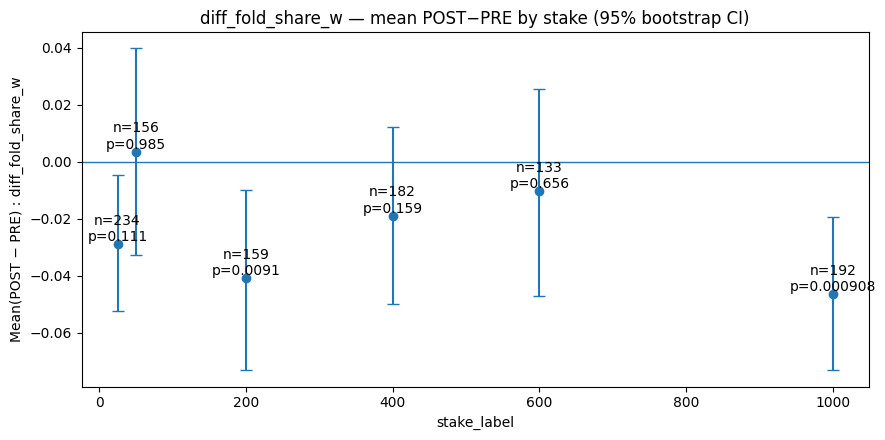

In [29]:
# ====== BLOCK: REPORT FIGURE — mean POST−PRE by stake (with 95% bootstrap CI + p-values) ======
# CTRL-F: BLOCK: REPORT FIGURE — mean POST−PRE by stake (with 95% bootstrap CI + p-values)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---- Choose metric to plot (one at a time for a clean report figure)
METRIC = "diff_fold_share_w"   # options: "diff_fold_share_w", "diff_brs_w", "diff_brs_nf_w"
N_BOOT = 2000
SEED = 42

# bootstrap RNG handled deterministically per (metric|stake)

# --- sanity
if "window_events" not in globals():
    raise ValueError("window_events not found. Run the WINDOW block first (it creates window_events).")
if "window_tests" not in globals():
    raise ValueError("window_tests not found. Run the WINDOW block first (it creates window_tests).")

# --- compute bootstrap CI per stake
rows = []
for stake, g in window_events.groupby("stake_label"):
    x = g[METRIC].dropna().values
    n = len(x)
    if n < 20:
        rows.append({"stake_label": stake, "n": n, "mean": np.nan, "ci_low": np.nan, "ci_high": np.nan})
        continue

    mean = float(np.mean(x))
    boot_rng = np.random.default_rng(_stable_seed(SEED, f"{METRIC}|{stake}"))
    idx = boot_rng.integers(0, n, size=(N_BOOT, n))
    boot_means = x[idx].mean(axis=1)
    ci_low, ci_high = np.quantile(boot_means, [0.025, 0.975])

    rows.append({"stake_label": stake, "n": int(n), "mean": mean, "ci_low": float(ci_low), "ci_high": float(ci_high)})

plot_tbl = pd.DataFrame(rows).sort_values("stake_label").reset_index(drop=True)

# --- attach p-values from Wilcoxon table
tests_sub = window_tests.loc[window_tests["metric"] == METRIC, ["stake_label", "p_value"]].copy()
plot_tbl = plot_tbl.merge(tests_sub, on="stake_label", how="left")

print("Plot table:")
display(plot_tbl)

# --- plot (one clean figure)
x = plot_tbl["stake_label"].values
y = plot_tbl["mean"].values
yerr_low = y - plot_tbl["ci_low"].values
yerr_high = plot_tbl["ci_high"].values - y

plt.figure(figsize=(9, 4.5))
plt.errorbar(x, y, yerr=[yerr_low, yerr_high], fmt="o", capsize=4)
plt.axhline(0, linewidth=1)
plt.xlabel("stake_label")
plt.ylabel(f"Mean(POST − PRE) : {METRIC}")
plt.title(f"{METRIC} — mean POST−PRE by stake (95% bootstrap CI)")

# annotate n and p-value above each point (short and readable)
for xi, yi, ni, pv in zip(plot_tbl["stake_label"], plot_tbl["mean"], plot_tbl["n"], plot_tbl["p_value"]):
    if pd.isna(yi):
        continue
    txt = f"n={ni}"
    if pd.notna(pv):
        txt += f"\np={pv:.3g}"
    plt.text(xi, yi, txt, ha="center", va="bottom")

plt.tight_layout()
plt.show()

Plot table (BRS):


,stake_label,n,mean,ci_low,ci_high,p_value
0,25,234,-0.012392,-0.032095,0.007285,0.313727
1,50,156,-0.003143,-0.027274,0.019980,0.987047
2,200,159,0.004306,-0.017565,0.024809,0.483696
3,400,182,-0.008786,-0.034988,0.015604,0.432062
4,600,133,-0.009554,-0.035238,0.017103,0.414775
5,1000,192,0.015857,-0.004787,0.037848,0.212152


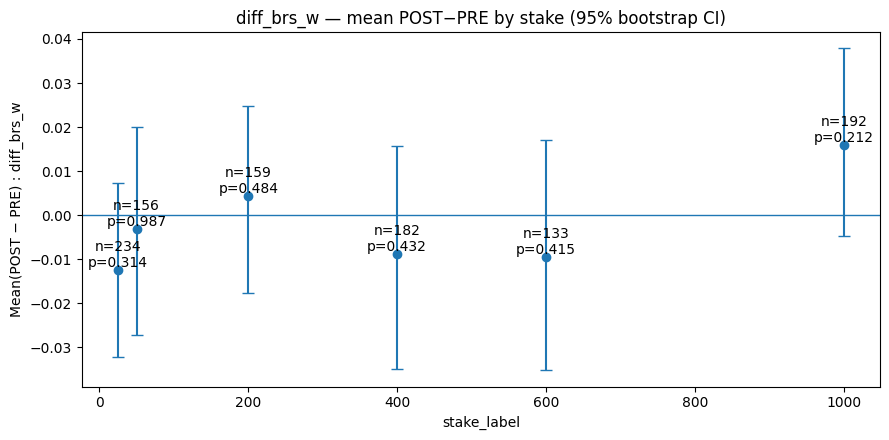

In [30]:
# ====== BLOCK: REPORT FIGURE — diff_brs_w (aggressiveness) ======
# CTRL-F: BLOCK: REPORT FIGURE — diff_brs_w (aggressiveness)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

METRIC = "diff_brs_w"   # aggressiveness: Bet/Raise Share (BRS) window diff = POST - PRE
N_BOOT = 2000
SEED = 42

# bootstrap RNG handled deterministically per (metric|stake)

if "window_events" not in globals():
    raise ValueError("window_events not found. Run the WINDOW block first (it creates window_events).")
if "window_tests" not in globals():
    raise ValueError("window_tests not found. Run the WINDOW block first (it creates window_tests).")

rows = []
for stake, g in window_events.groupby("stake_label"):
    x = g[METRIC].dropna().values
    n = len(x)
    if n < 20:
        rows.append({"stake_label": stake, "n": n, "mean": np.nan, "ci_low": np.nan, "ci_high": np.nan})
        continue

    mean = float(np.mean(x))
    boot_rng = np.random.default_rng(_stable_seed(SEED, f"{METRIC}|{stake}"))
    idx = boot_rng.integers(0, n, size=(N_BOOT, n))
    boot_means = x[idx].mean(axis=1)
    ci_low, ci_high = np.quantile(boot_means, [0.025, 0.975])

    rows.append({"stake_label": stake, "n": int(n), "mean": mean, "ci_low": float(ci_low), "ci_high": float(ci_high)})

plot_tbl_brs = pd.DataFrame(rows).sort_values("stake_label").reset_index(drop=True)

tests_sub = window_tests.loc[window_tests["metric"] == METRIC, ["stake_label", "p_value"]].copy()
plot_tbl_brs = plot_tbl_brs.merge(tests_sub, on="stake_label", how="left")

print("Plot table (BRS):")
display(plot_tbl_brs)

x = plot_tbl_brs["stake_label"].values
y = plot_tbl_brs["mean"].values
yerr_low = y - plot_tbl_brs["ci_low"].values
yerr_high = plot_tbl_brs["ci_high"].values - y

plt.figure(figsize=(9, 4.5))
plt.errorbar(x, y, yerr=[yerr_low, yerr_high], fmt="o", capsize=4)
plt.axhline(0, linewidth=1)
plt.xlabel("stake_label")
plt.ylabel("Mean(POST − PRE) : diff_brs_w")
plt.title("diff_brs_w — mean POST−PRE by stake (95% bootstrap CI)")

for xi, yi, ni, pv in zip(plot_tbl_brs["stake_label"], plot_tbl_brs["mean"], plot_tbl_brs["n"], plot_tbl_brs["p_value"]):
    if pd.isna(yi):
        continue
    txt = f"n={ni}"
    if pd.notna(pv):
        txt += f"\np={pv:.3g}"
    plt.text(xi, yi, txt, ha="center", va="bottom")

plt.tight_layout()
plt.show()

=== SIZING WINDOW: event-level table ===
size_window_events shape: (1123, 9)
paired_size shape (events with sizing PRE and POST): (927, 10)


,stake_label,player_id,event_hand_id,pre_n_bets,pre_mean_size_bb,pre_median_size_bb,post_n_bets,post_mean_size_bb,post_median_size_bb,diff_mean_size_bb
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,15.0,3.933333,3.0,11.0,5.363636,4.0,1.430303
1,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,12.0,5.166667,3.5,10.0,5.700000,4.0,0.533333
2,25,+dHwJza6cu+q_a5ac9a4a30,60299272870,9.0,5.555556,4.0,9.0,3.777778,3.0,-1.777778
3,25,+dHwJza6cu+q_a5ac9a4a30,60300200508,8.0,3.500000,3.0,10.0,10.380000,3.0,6.880000
4,25,+dHwJza6cu+q_a5ac9a4a30,60301021612,10.0,7.780000,3.0,5.0,8.560000,8.6,0.780000
5,25,0HNphrhg9+R3_f5a9250e19,60044924406,4.0,2.250000,1.5,2.0,3.500000,3.5,1.250000
6,25,0HNphrhg9+R3_f5a9250e19,60046736790,5.0,3.200000,4.0,4.0,2.750000,2.0,-0.450000
7,25,0cE1GlmMnTw3_6f097be0e3,60164728390,10.0,3.900000,2.0,12.0,6.016667,3.0,2.116667
8,25,0cE1GlmMnTw3_6f097be0e3,60165701598,12.0,6.266667,2.0,6.0,2.666667,2.0,-3.600000
9,25,0cE1GlmMnTw3_6f097be0e3,60235916742,13.0,3.307692,4.0,7.0,3.000000,2.0,-0.307692



=== SIZING SUMMARY BY STAKE (diff = POST - PRE, in BB) ===


,stake_label,n,mean_diff_bb,ci_low,ci_high,median_diff_bb,wilcoxon_stat,p_value
0,25,207,0.162866,-0.788231,1.040376,0.200000,9187.5,0.200869
1,50,126,0.554156,-0.438378,1.490588,0.418750,3371.5,0.163139
2,200,141,0.366620,-1.080871,1.741906,0.684848,4202.0,0.098192
3,400,157,0.416528,-0.535667,1.460118,0.000000,5663.5,0.781903
4,600,122,-0.109962,-1.186097,0.904748,-0.069444,3366.0,0.816115
5,1000,174,0.186824,-1.059516,1.392463,0.361111,6956.0,0.540318


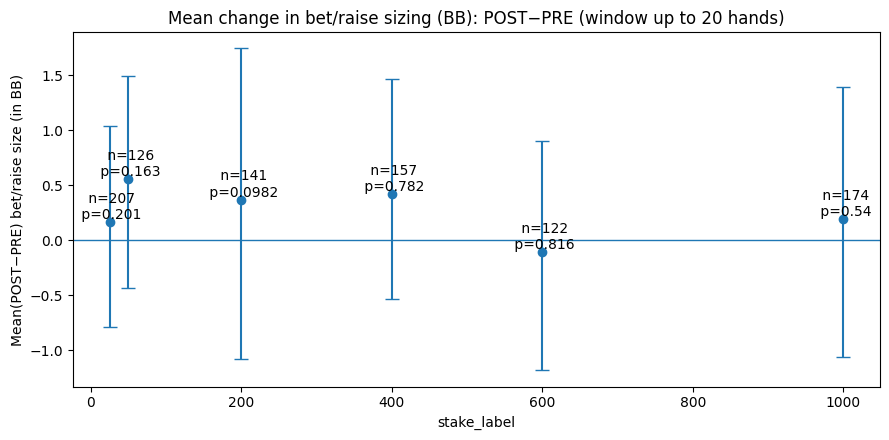

In [31]:
# ====== BLOCK: WINDOW SIZING (BET/RAISE AMOUNT) — PRE vs POST + stats + simple plot ======
# CTRL-F: BLOCK: WINDOW SIZING (BET/RAISE AMOUNT) — PRE vs POST + stats + simple plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from IPython.display import display

# -------------------------
# Parameters
# -------------------------
MAX_DELTA = 20          # window size (up to 20 hands before / after)
N_BOOT = 2000           # bootstrap reps for CI on mean(diff)
SEED = 42
MIN_N = 20              # minimum paired events per stake to run Wilcoxon

# bootstrap RNG handled deterministically per (metric|stake)

# -------------------------
# Required objects
# -------------------------
required = ["pr_actions", "pa_actions", "hands"]
missing = [k for k in required if k not in globals()]
if missing:
    raise ValueError(f"Missing required objects in memory: {missing}. (Need pr_actions, pa_actions, hands)")

# -------------------------
# 1) Build BB mapping by stake
# -------------------------
# Prefer 'big_blind' if present; otherwise fall back to stake_label/100 (e.g., 25 -> 0.25)
if "big_blind" in hands.columns:
    bb_by_stake = (hands.groupby("stake_label")["big_blind"].median()).to_dict()
else:
    bb_by_stake = {float(s): float(s)/100.0 for s in sorted(hands["stake_label"].dropna().unique())}

# -------------------------
# 2) Prepare bet/raise actions with sizing in BB
# -------------------------
def prep_sizes(df, delta_col, side_label):
    need_cols = ["stake_label","player_id","event_hand_id", delta_col, "decision_bucket", "amount"]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise ValueError(f"{side_label} is missing columns: {miss}")

    x = df.copy()
    x = x.loc[x[delta_col].between(1, MAX_DELTA), need_cols].copy()
    x = x.loc[x["decision_bucket"].eq("bet_or_raise")].copy()

    x["amount"] = pd.to_numeric(x["amount"], errors="coerce")
    x = x.dropna(subset=["amount"])
    x = x.loc[x["amount"] > 0].copy()

    # convert to BB using stake's big blind
    x["big_blind"] = x["stake_label"].map(bb_by_stake)
    x = x.dropna(subset=["big_blind"])
    x = x.loc[x["big_blind"] > 0].copy()

    x[f"{side_label}_size_bb"] = x["amount"] / x["big_blind"]
    return x[["stake_label","player_id","event_hand_id", f"{side_label}_size_bb"]]

pre_sizes_long  = prep_sizes(pr_actions, "delta_before", "pre")
post_sizes_long = prep_sizes(pa_actions, "delta_after",  "post")

# -------------------------
# 3) Aggregate per event (window-level sizing)
# -------------------------
pre_evt = (pre_sizes_long
           .groupby(["stake_label","player_id","event_hand_id"])
           .agg(pre_n_bets=("pre_size_bb","size"),
                pre_mean_size_bb=("pre_size_bb","mean"),
                pre_median_size_bb=("pre_size_bb","median"))
           .reset_index())

post_evt = (post_sizes_long
            .groupby(["stake_label","player_id","event_hand_id"])
            .agg(post_n_bets=("post_size_bb","size"),
                 post_mean_size_bb=("post_size_bb","mean"),
                 post_median_size_bb=("post_size_bb","median"))
            .reset_index())

size_window_events = (pre_evt
                      .merge(post_evt, on=["stake_label","player_id","event_hand_id"], how="outer"))

# We compare sizing only when BOTH sides have at least 1 bet/raise action
paired_size = size_window_events.dropna(subset=["pre_mean_size_bb","post_mean_size_bb"]).copy()
paired_size["diff_mean_size_bb"] = paired_size["post_mean_size_bb"] - paired_size["pre_mean_size_bb"]

print("=== SIZING WINDOW: event-level table ===")
print("size_window_events shape:", size_window_events.shape)
print("paired_size shape (events with sizing PRE and POST):", paired_size.shape)
display(paired_size.head(10))

# -------------------------
# 4) Stake-level summary + Wilcoxon + bootstrap CI on mean(diff)
# -------------------------
rows = []
for stake, g in paired_size.groupby("stake_label"):
    diffs = g["diff_mean_size_bb"].to_numpy()
    n = len(diffs)

    if n < MIN_N:
        rows.append({
            "stake_label": stake, "n": n,
            "mean_diff_bb": np.nan, "ci_low": np.nan, "ci_high": np.nan,
            "median_diff_bb": np.nan,
            "wilcoxon_stat": np.nan, "p_value": np.nan
        })
        continue

    mean_diff = float(np.mean(diffs))
    median_diff = float(np.median(diffs))

    # paired Wilcoxon test vs 0 median difference
    try:
        stat, p = wilcoxon(diffs)
        stat, p = float(stat), float(p)
    except Exception:
        stat, p = np.nan, np.nan

    # bootstrap CI for mean(diff)
    # bootstrap CI for mean(diff) — deterministic per (metric|stake)
    boot_rng = np.random.default_rng(_stable_seed(SEED, f"diff_mean_size_bb|{stake}"))
    samp_idx = boot_rng.integers(0, n, size=(N_BOOT, n))
    boot = diffs[samp_idx].mean(axis=1)
    ci_low, ci_high = np.quantile(boot, [0.025, 0.975])

    rows.append({
        "stake_label": stake, "n": int(n),
        "mean_diff_bb": mean_diff, "ci_low": float(ci_low), "ci_high": float(ci_high),
        "median_diff_bb": median_diff,
        "wilcoxon_stat": stat, "p_value": p
    })

size_plot_table = pd.DataFrame(rows).sort_values("stake_label").reset_index(drop=True)

print("\n=== SIZING SUMMARY BY STAKE (diff = POST - PRE, in BB) ===")
display(size_plot_table)

# -------------------------
# 5) Simple plot (mean diff with 95% bootstrap CI)
# -------------------------
plot_tbl = size_plot_table.dropna(subset=["mean_diff_bb"]).copy()
if len(plot_tbl) == 0:
    print("Not enough data to plot (all stakes under MIN_N or no paired sizing).")
else:
    x = plot_tbl["stake_label"].to_numpy()
    y = plot_tbl["mean_diff_bb"].to_numpy()
    yerr = np.vstack([y - plot_tbl["ci_low"].to_numpy(), plot_tbl["ci_high"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=5)
    plt.axhline(0, linewidth=1)
    plt.title(f"Mean change in bet/raise sizing (BB): POST−PRE (window up to {MAX_DELTA} hands)")
    plt.xlabel("stake_label")
    plt.ylabel("Mean(POST−PRE) bet/raise size (in BB)")

    # annotate with n and p-value
    for xi, yi, ni, pi in zip(plot_tbl["stake_label"], plot_tbl["mean_diff_bb"], plot_tbl["n"], plot_tbl["p_value"]):
        if pd.notna(pi):
            plt.text(xi, yi, f" n={int(ni)}\n p={pi:.3g}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

=== SIZING (MEDIAN) WINDOW: event-level table ===
evt shape: (1123, 7)
paired shape (events with median sizing PRE and POST): (927, 8)


,stake_label,player_id,event_hand_id,pre_n_bets,pre_median_size_bb,post_n_bets,post_median_size_bb,diff_median_size_bb
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,15.0,3.0,11.0,4.0,1.0
1,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,12.0,3.5,10.0,4.0,0.5
2,25,+dHwJza6cu+q_a5ac9a4a30,60299272870,9.0,4.0,9.0,3.0,-1.0
3,25,+dHwJza6cu+q_a5ac9a4a30,60300200508,8.0,3.0,10.0,3.0,0.0
4,25,+dHwJza6cu+q_a5ac9a4a30,60301021612,10.0,3.0,5.0,8.6,5.6
5,25,0HNphrhg9+R3_f5a9250e19,60044924406,4.0,1.5,2.0,3.5,2.0
6,25,0HNphrhg9+R3_f5a9250e19,60046736790,5.0,4.0,4.0,2.0,-2.0
7,25,0cE1GlmMnTw3_6f097be0e3,60164728390,10.0,2.0,12.0,3.0,1.0
8,25,0cE1GlmMnTw3_6f097be0e3,60165701598,12.0,2.0,6.0,2.0,0.0
9,25,0cE1GlmMnTw3_6f097be0e3,60235916742,13.0,4.0,7.0,2.0,-2.0



=== SIZING (MEDIAN) SUMMARY BY STAKE (diff = POST - PRE, in BB) ===


,stake_label,n,mean_diff_bb,ci_low,ci_high,median_diff_bb,wilcoxon_stat,p_value
0,25,207,0.575362,-0.012597,1.171498,0.0,5349.5,0.047557
1,50,126,0.105556,-0.665893,0.802024,0.0,2074.0,0.160528
2,200,141,-0.415426,-1.467230,0.432828,0.0,2932.0,0.499266
3,400,157,0.053025,-0.566730,0.751812,0.0,2927.5,0.961970
4,600,122,-0.017350,-0.777268,0.764813,0.0,1896.5,0.663607
5,1000,174,0.010201,-0.889425,0.768330,0.0,3809.5,0.296475


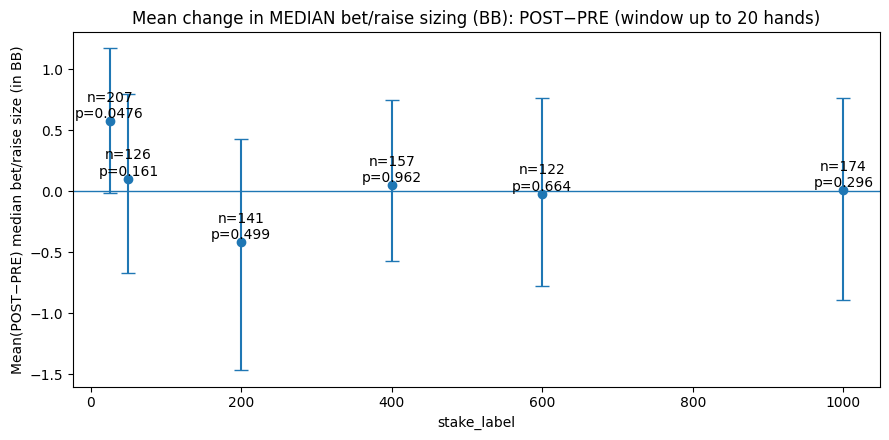

In [32]:
# ====== BLOCK: WINDOW SIZING (MEDIAN) — PRE vs POST + stats + simple plot ======
# CTRL-F: BLOCK: WINDOW SIZING (MEDIAN) — PRE vs POST + stats + simple plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from IPython.display import display

# -------------------------
# Parameters
# -------------------------
MAX_DELTA = 20          # window size (up to 20 hands before / after)
N_BOOT = 2000           # bootstrap reps for CI on mean(diff)
SEED = 42
MIN_N = 20              # minimum paired events per stake to run Wilcoxon

# bootstrap RNG handled deterministically per (metric|stake)

# -------------------------
# Required objects
# -------------------------
required = ["pr_actions", "pa_actions", "hands"]
missing = [k for k in required if k not in globals()]
if missing:
    raise ValueError(f"Missing required objects in memory: {missing}. (Need pr_actions, pa_actions, hands)")

# -------------------------
# 1) Build BB mapping by stake
# -------------------------
# Prefer 'big_blind' if present; otherwise fall back to stake_label/100 (e.g., 25 -> 0.25)
if "big_blind" in hands.columns:
    bb_by_stake = (hands.groupby("stake_label")["big_blind"].median()).to_dict()
else:
    bb_by_stake = {float(s): float(s)/100.0 for s in sorted(hands["stake_label"].dropna().unique())}

# -------------------------
# 2) Keep only HERO bet/raise actions and compute size in BB
# -------------------------
def prep_sizes(df, delta_col, side_label):
    need_cols = ["stake_label","player_id","event_hand_id", delta_col, "decision_bucket", "amount"]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise ValueError(f"{side_label} is missing columns: {miss}")

    x = df.copy()
    x = x.loc[x[delta_col].between(1, MAX_DELTA), need_cols].copy()
    x = x.loc[x["decision_bucket"].eq("bet_or_raise")].copy()

    x["amount"] = pd.to_numeric(x["amount"], errors="coerce")
    x = x.dropna(subset=["amount"])
    x = x.loc[x["amount"] > 0].copy()

    x["big_blind"] = x["stake_label"].map(bb_by_stake)
    x = x.dropna(subset=["big_blind"])
    x = x.loc[x["big_blind"] > 0].copy()

    x[f"{side_label}_size_bb"] = x["amount"] / x["big_blind"]
    return x[["stake_label","player_id","event_hand_id", f"{side_label}_size_bb"]]

pre_sizes_long  = prep_sizes(pr_actions, "delta_before", "pre")
post_sizes_long = prep_sizes(pa_actions, "delta_after",  "post")

# -------------------------
# 3) Aggregate per event: median sizing in window
# -------------------------
pre_evt = (pre_sizes_long
           .groupby(["stake_label","player_id","event_hand_id"])
           .agg(pre_n_bets=("pre_size_bb","size"),
                pre_median_size_bb=("pre_size_bb","median"))
           .reset_index())

post_evt = (post_sizes_long
            .groupby(["stake_label","player_id","event_hand_id"])
            .agg(post_n_bets=("post_size_bb","size"),
                 post_median_size_bb=("post_size_bb","median"))
            .reset_index())

evt = pre_evt.merge(post_evt, on=["stake_label","player_id","event_hand_id"], how="outer")

# Paired = must have a median sizing both PRE and POST (=> at least 1 bet/raise on each side)
paired = evt.dropna(subset=["pre_median_size_bb","post_median_size_bb"]).copy()
paired["diff_median_size_bb"] = paired["post_median_size_bb"] - paired["pre_median_size_bb"]

print("=== SIZING (MEDIAN) WINDOW: event-level table ===")
print("evt shape:", evt.shape)
print("paired shape (events with median sizing PRE and POST):", paired.shape)
display(paired.head(10))

# -------------------------
# 4) Stake-level summary + Wilcoxon + bootstrap CI on mean(diff)
# -------------------------
rows = []
for stake, g in paired.groupby("stake_label"):
    diffs = g["diff_median_size_bb"].to_numpy()
    n = len(diffs)

    if n < MIN_N:
        rows.append({
            "stake_label": stake, "n": int(n),
            "mean_diff_bb": np.nan, "ci_low": np.nan, "ci_high": np.nan,
            "median_diff_bb": np.nan,
            "wilcoxon_stat": np.nan, "p_value": np.nan
        })
        continue

    mean_diff = float(np.mean(diffs))
    median_diff = float(np.median(diffs))

    try:
        stat, p = wilcoxon(diffs)
        stat, p = float(stat), float(p)
    except Exception:
        stat, p = np.nan, np.nan

    # bootstrap CI for mean(diff) — deterministic per (metric|stake)
    boot_rng = np.random.default_rng(_stable_seed(SEED, f"diff_median_size_bb|{stake}"))
    samp_idx = boot_rng.integers(0, n, size=(N_BOOT, n))
    boot = diffs[samp_idx].mean(axis=1)
    ci_low, ci_high = np.quantile(boot, [0.025, 0.975])

    rows.append({
        "stake_label": stake, "n": int(n),
        "mean_diff_bb": mean_diff, "ci_low": float(ci_low), "ci_high": float(ci_high),
        "median_diff_bb": median_diff,
        "wilcoxon_stat": stat, "p_value": p
    })

median_size_plot_table = pd.DataFrame(rows).sort_values("stake_label").reset_index(drop=True)

print("\n=== SIZING (MEDIAN) SUMMARY BY STAKE (diff = POST - PRE, in BB) ===")
display(median_size_plot_table)

# -------------------------
# 5) Simple plot (mean diff with 95% bootstrap CI)
# -------------------------
plot_tbl = median_size_plot_table.dropna(subset=["mean_diff_bb"]).copy()
if len(plot_tbl) == 0:
    print("Not enough data to plot (all stakes under MIN_N or no paired median sizing).")
else:
    x = plot_tbl["stake_label"].to_numpy()
    y = plot_tbl["mean_diff_bb"].to_numpy()
    yerr = np.vstack([y - plot_tbl["ci_low"].to_numpy(), plot_tbl["ci_high"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=5)
    plt.axhline(0, linewidth=1)
    plt.title(f"Mean change in MEDIAN bet/raise sizing (BB): POST−PRE (window up to {MAX_DELTA} hands)")
    plt.xlabel("stake_label")
    plt.ylabel("Mean(POST−PRE) median bet/raise size (in BB)")

    for xi, yi, ni, pi in zip(plot_tbl["stake_label"], plot_tbl["mean_diff_bb"], plot_tbl["n"], plot_tbl["p_value"]):
        if pd.notna(pi):
            encourages = f"n={int(ni)}\np={pi:.3g}"
            plt.text(xi, yi, encourages, ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

Chosen mean sizing DF: paired_size
Top candidates (n_stakes, n_nonnull, n_rows, name):
   (6, 927, 927, 'paired_size')

Chosen median sizing DF: paired
Top candidates (n_stakes, n_nonnull, n_rows, name):
   (6, 927, 927, 'paired')
   (1, 174, 174, 'g')

Stakes to plot: [np.int64(25), np.int64(50), np.int64(200), np.int64(400), np.int64(600), np.int64(1000)]


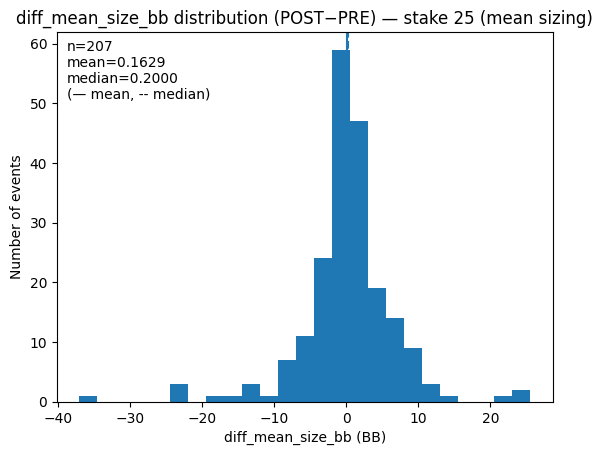

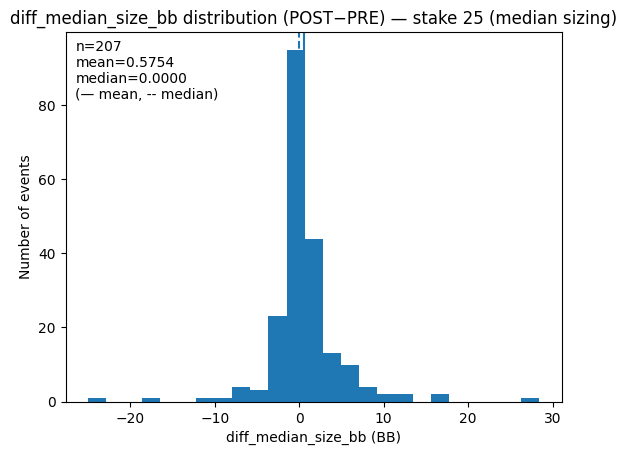

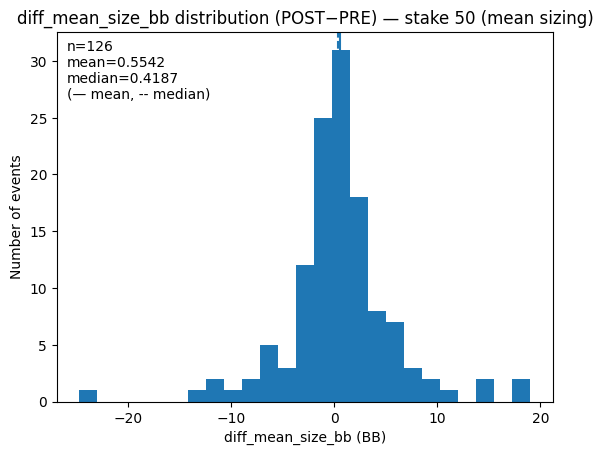

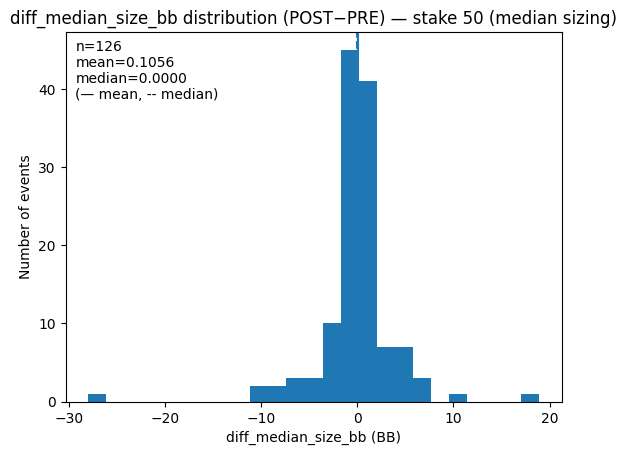

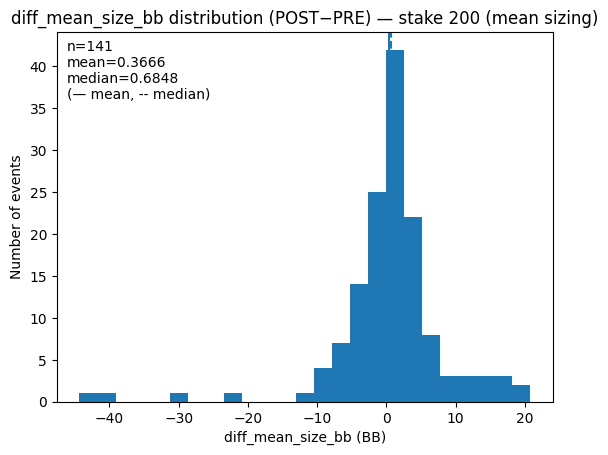

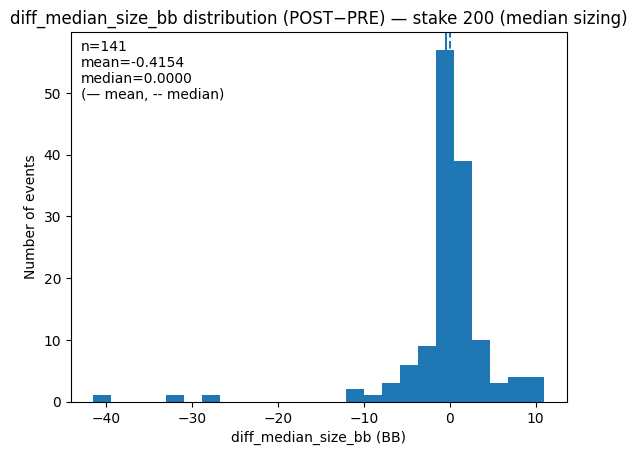

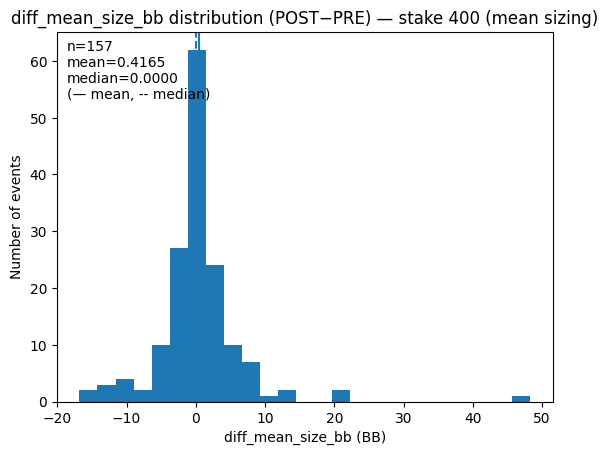

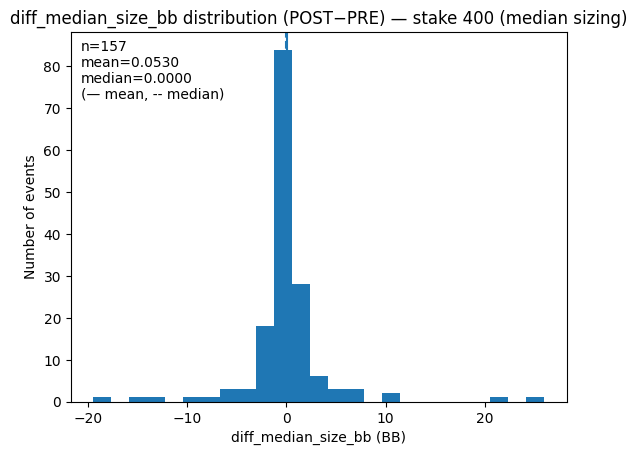

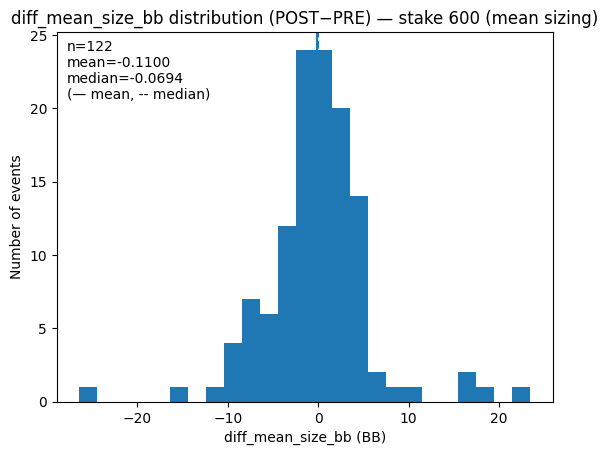

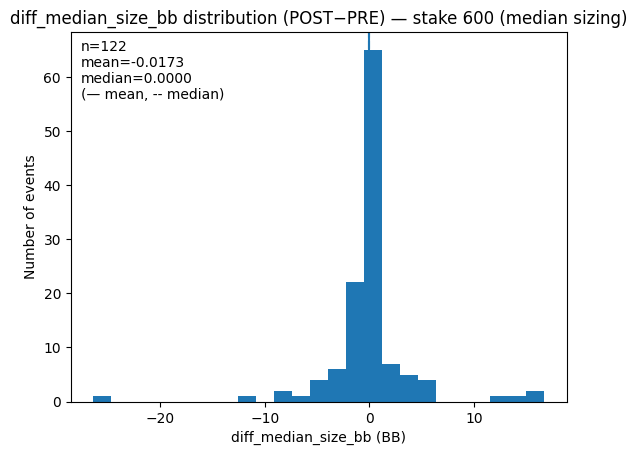

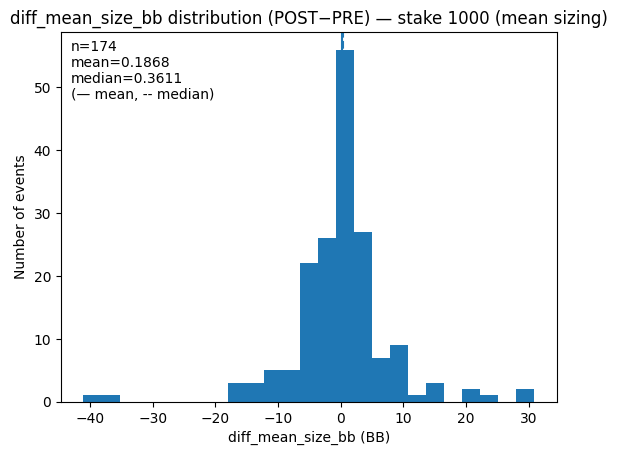

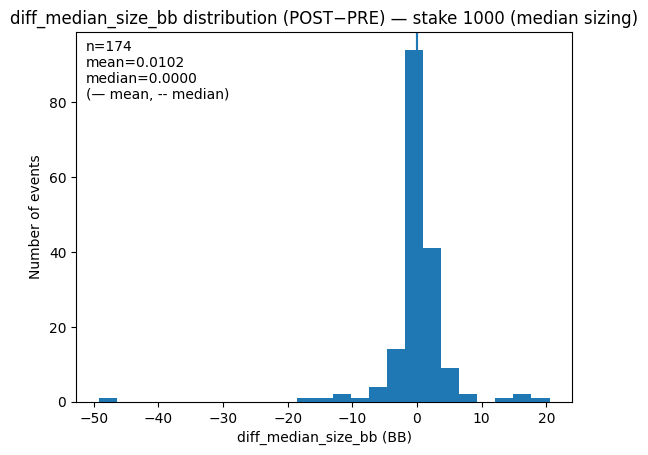

In [33]:
# ====== PLOT: SIZING DIFF DISTRIBUTION (mean & median) ======
# CTRL-F: PLOT: SIZING DIFF DISTRIBUTION (ALL STAKES, ROBUST PICK)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _find_best_df(diff_col: str, stake_col: str = "stake_label"):
    """
    Find the 'best' DataFrame in globals() that contains [stake_col, diff_col].
    Best = max unique stakes, then max non-NaN in diff_col, then max rows.
    """
    cands = []
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame) and (stake_col in obj.columns) and (diff_col in obj.columns):
            try:
                n_stakes = int(pd.Series(obj[stake_col]).dropna().nunique())
            except Exception:
                n_stakes = 0
            try:
                n_nonnull = int(pd.Series(obj[diff_col]).notna().sum())
            except Exception:
                n_nonnull = 0
            n_rows = int(obj.shape[0])
            cands.append((n_stakes, n_nonnull, n_rows, name, obj))

    if not cands:
        return None, None, []

    cands_sorted = sorted(cands, key=lambda x: (x[0], x[1], x[2]), reverse=True)
    best = cands_sorted[0]
    # return also a short debug list
    debug = [(a, b, c, d) for (a, b, c, d, _) in cands_sorted[:10]]
    return best[3], best[4], debug

def _plot_hist_for_stake(df, diff_col, stake_label, title_suffix):
    d = df.loc[df["stake_label"] == stake_label, diff_col].dropna()
    if d.empty:
        print(f"[stake={stake_label}] No data for {diff_col} -> SKIP")
        return
    d = d.astype(float)
    n = int(d.shape[0])
    mean_v = float(d.mean())
    med_v  = float(d.median())

    plt.figure()
    plt.hist(d.values, bins=25)
    plt.axvline(mean_v, linestyle="-")
    plt.axvline(med_v, linestyle="--")
    plt.title(f"{diff_col} distribution (POST−PRE) — stake {stake_label} {title_suffix}")
    plt.xlabel(f"{diff_col} (BB)")
    plt.ylabel("Number of events")
    plt.text(
        0.02, 0.98,
        f"n={n}\nmean={mean_v:.4f}\nmedian={med_v:.4f}\n(— mean, -- median)",
        transform=plt.gca().transAxes,
        va="top",
    )
    plt.show()

# ---- Pick best DF for MEAN sizing diff ----
mean_name, mean_df, mean_debug = _find_best_df("diff_mean_size_bb")
print("Chosen mean sizing DF:", mean_name)
print("Top candidates (n_stakes, n_nonnull, n_rows, name):")
for row in mean_debug:
    print("  ", row)

# ---- Pick best DF for MEDIAN sizing diff ----
med_name, med_df, med_debug = _find_best_df("diff_median_size_bb")
print("\nChosen median sizing DF:", med_name)
print("Top candidates (n_stakes, n_nonnull, n_rows, name):")
for row in med_debug:
    print("  ", row)

if mean_df is None or med_df is None:
    raise ValueError(
        "Missing sizing diff DataFrames. Need both diff_mean_size_bb and diff_median_size_bb with stake_label."
    )

# Stakes to plot = union of stakes present in either DF
stakes = sorted(set(mean_df["stake_label"].dropna().unique()) | set(med_df["stake_label"].dropna().unique()))
print("\nStakes to plot:", stakes)

# Plot BOTH histograms for EACH stake
for st in stakes:
    _plot_hist_for_stake(mean_df, "diff_mean_size_bb", st, "(mean sizing)")
    _plot_hist_for_stake(med_df,  "diff_median_size_bb", st, "(median sizing)")


In [34]:
# ====== EXPORT: ML EVENT TABLE (merge freq + sizing into 1 event-level df) ======
# CTRL-F: EXPORT: ML EVENT TABLE

import os
import pandas as pd
import numpy as np

def _find_df(required_cols, prefer_cols=None):
    """
    Find a pandas DataFrame in globals() that contains required_cols.
    If multiple, prefer the one that also contains prefer_cols (and has more rows).
    """
    best_name, best_df, best_score = None, None, -1
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            cols = set(obj.columns)
            if all(c in cols for c in required_cols):
                score = 0
                if prefer_cols:
                    score += sum(1 for c in prefer_cols if c in cols)
                # prefer more rows as tie-breaker
                score = score * 1_000_000 + len(obj)
                if score > best_score:
                    best_name, best_df, best_score = name, obj, score
    return best_name, best_df

# 1) Base event df = the one that has fold/brs window diffs (your main "window" table)
base_req = ["stake_label", "player_id", "event_hand_id"]
base_prefer = [
    "diff_fold_share_w", "diff_brs_w",
    "pre_fold_share_w", "post_fold_share_w",
    "pre_brs_w", "post_brs_w",
    "n_hands_pre", "n_hands_post"
]
base_name, base_df = _find_df(base_req, base_prefer)
if base_df is None:
    raise ValueError(f"Could not find a base event DataFrame with columns {base_req} in memory.")

print("Using BASE df:", base_name, "| shape:", base_df.shape)

ml_events = base_df.copy()

# 2) Mean sizing df (diff_mean_size_bb)
mean_req = ["stake_label", "player_id", "event_hand_id", "diff_mean_size_bb"]
mean_prefer = ["pre_mean_size_bb", "post_mean_size_bb", "pre_n_bets", "post_n_bets"]
mean_name, mean_df = _find_df(mean_req, mean_prefer)

print("Mean sizing df:", mean_name, "| shape:", None if mean_df is None else mean_df.shape)

if mean_df is not None:
    keep = ["stake_label", "player_id", "event_hand_id",
            "pre_n_bets", "post_n_bets",
            "pre_mean_size_bb", "post_mean_size_bb", "diff_mean_size_bb"]
    keep = [c for c in keep if c in mean_df.columns]

    tmp = mean_df[keep].copy()
    rename = {}
    if "pre_n_bets" in tmp.columns:  rename["pre_n_bets"]  = "pre_n_bets_mean"
    if "post_n_bets" in tmp.columns: rename["post_n_bets"] = "post_n_bets_mean"
    tmp = tmp.rename(columns=rename)

    ml_events = ml_events.merge(tmp, on=["stake_label", "player_id", "event_hand_id"], how="left")

# 3) Median sizing df (diff_median_size_bb)
med_req = ["stake_label", "player_id", "event_hand_id", "diff_median_size_bb"]
med_prefer = ["pre_median_size_bb", "post_median_size_bb", "pre_n_bets", "post_n_bets"]
med_name, med_df = _find_df(med_req, med_prefer)

print("Median sizing df:", med_name, "| shape:", None if med_df is None else med_df.shape)

if med_df is not None:
    keep = ["stake_label", "player_id", "event_hand_id",
            "pre_n_bets", "post_n_bets",
            "pre_median_size_bb", "post_median_size_bb", "diff_median_size_bb"]
    keep = [c for c in keep if c in med_df.columns]

    tmp = med_df[keep].copy()
    rename = {}
    if "pre_n_bets" in tmp.columns:  rename["pre_n_bets"]  = "pre_n_bets_median"
    if "post_n_bets" in tmp.columns: rename["post_n_bets"] = "post_n_bets_median"
    tmp = tmp.rename(columns=rename)

    ml_events = ml_events.merge(tmp, on=["stake_label", "player_id", "event_hand_id"], how="left")

print("\nml_events shape:", ml_events.shape)

key_cols = [c for c in [
    "diff_fold_share_w", "diff_brs_w",
    "diff_mean_size_bb", "diff_median_size_bb"
] if c in ml_events.columns]
print("Key DIFF columns found:", key_cols)

display(ml_events.head(5))

# 4) Export (Drive if BASE_DIR exists, else local)
out_dir = None
if "BASE_DIR" in globals() and isinstance(BASE_DIR, str) and os.path.exists(BASE_DIR):
    out_dir = os.path.join(BASE_DIR, "_exports")
else:
    out_dir = "./_exports"

os.makedirs(out_dir, exist_ok=True)

out_csv = os.path.join(out_dir, "ml_events.csv")
ml_events.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)

# Parquet is optional (depends on environment)
out_parquet = os.path.join(out_dir, "ml_events.parquet")
try:
    ml_events.to_parquet(out_parquet, index=False)
    print("Saved Parquet:", out_parquet)
except Exception as e:
    print("Parquet not saved (ok). Reason:", repr(e))


Using BASE df: window_events | shape: (1056, 16)
Mean sizing df: paired_size | shape: (927, 10)
Median sizing df: paired | shape: (927, 8)

ml_events shape: (1056, 26)
Key DIFF columns found: ['diff_fold_share_w', 'diff_brs_w', 'diff_mean_size_bb', 'diff_median_size_bb']


,stake_label,player_id,event_hand_id,n_hands_pre,n_decisions_pre,pre_fold_share_w,pre_brs_w,pre_brs_nf_w,n_hands_post,n_decisions_post,...,pre_n_bets_mean,post_n_bets_mean,pre_mean_size_bb,post_mean_size_bb,diff_mean_size_bb,pre_n_bets_median,post_n_bets_median,pre_median_size_bb,post_median_size_bb,diff_median_size_bb
0,25,+dHwJza6cu+q_a5ac9a4a30,60190756454,20,46,0.195652,0.326087,0.405405,19,55,...,15.0,11.0,3.933333,5.363636,1.430303,15.0,11.0,3.0,4.0,1.0
1,25,+dHwJza6cu+q_a5ac9a4a30,60234028716,19,49,0.204082,0.244898,0.307692,19,35,...,12.0,10.0,5.166667,5.700000,0.533333,12.0,10.0,3.5,4.0,0.5
2,25,+dHwJza6cu+q_a5ac9a4a30,60299272870,18,30,0.433333,0.300000,0.529412,20,43,...,9.0,9.0,5.555556,3.777778,-1.777778,9.0,9.0,4.0,3.0,-1.0
3,25,+dHwJza6cu+q_a5ac9a4a30,60300200508,19,38,0.236842,0.210526,0.275862,19,43,...,8.0,10.0,3.500000,10.380000,6.880000,8.0,10.0,3.0,3.0,0.0
4,25,+dHwJza6cu+q_a5ac9a4a30,60301021612,19,44,0.295455,0.227273,0.322581,13,31,...,10.0,5.0,7.780000,8.560000,0.780000,10.0,5.0,3.0,8.6,5.6


Saved CSV: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.csv
Saved Parquet: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/ml_events.parquet


In [35]:
# ===== REPORT TABLE 1: ONE-PAGE SUMMARY (all stakes) =====
# CTRL-F: REPORT TABLE 1: ONE-PAGE SUMMARY (all stakes)

import os, glob
import numpy as np
import pandas as pd

# --- 0) Get ml_events (from memory or from exported file) ---
ml_events_path = None

if "ml_events" in globals() and isinstance(ml_events, pd.DataFrame):
    df = ml_events.copy()
else:
    # Try to find the exported file automatically in Drive
    candidates = []
    for pattern in [
        "/content/drive/MyDrive/**/_exports/ml_events.parquet",
        "/content/drive/MyDrive/**/_exports/ml_events.csv",
        "/content/drive/MyDrive/**/ml_events.parquet",
        "/content/drive/MyDrive/**/ml_events.csv",
    ]:
        candidates += glob.glob(pattern, recursive=True)

    if len(candidates) == 0:
        raise FileNotFoundError(
            "Could not find ml_events in memory, and no exported ml_events.(parquet/csv) found in Drive.\n"
            "Re-run the export cell that saves ml_events, then re-run this cell."
        )

    # pick most recent
    candidates = sorted(candidates, key=lambda p: os.path.getmtime(p), reverse=True)
    ml_events_path = candidates[0]
    print("Loading ml_events from:", ml_events_path)

    if ml_events_path.endswith(".parquet"):
        df = pd.read_parquet(ml_events_path)
    else:
        df = pd.read_csv(ml_events_path)

# --- 1) Define metrics we want in the report table ---
needed = [
    "stake_label",
    "diff_fold_share_w",
    "diff_brs_w",
    "diff_mean_size_bb",
    "diff_median_size_bb",
]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"ml_events is missing required columns: {missing}")

metrics = {
    "Fold freq (Δ POST−PRE)": "diff_fold_share_w",
    "Bet/Raise freq (Δ POST−PRE)": "diff_brs_w",
    "Mean sizing in BB (Δ POST−PRE)": "diff_mean_size_bb",
    "Median sizing in BB (Δ POST−PRE)": "diff_median_size_bb",
}

# --- 2) Wilcoxon import (with safe fallback) ---
try:
    from scipy.stats import wilcoxon
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False
    print("WARNING: scipy not available -> p-values will be NaN.")

# --- 3) Helpers: bootstrap CI + wilcoxon p-value ---

def bootstrap_ci_mean(x: np.ndarray, n_boot: int = N_BOOT, seed_key: str = ""):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(_stable_seed(SEED, seed_key))
    idx = rng.integers(0, n, size=(n_boot, n))
    boot_means = x[idx].mean(axis=1)
    return (float(np.quantile(boot_means, 0.025)), float(np.quantile(boot_means, 0.975)))

def wilcoxon_p(x: np.ndarray):
    if (not HAS_SCIPY) or len(x) == 0:
        return np.nan
    x = x.astype(float)
    # If all values are 0 => no difference at all
    if np.allclose(x, 0.0):
        return 1.0
    try:
        stat, p = wilcoxon(x, zero_method="wilcox", alternative="two-sided", mode="auto")
        return float(p)
    except Exception:
        # sometimes fails with too many zeros / ties
        return np.nan

# --- 4) Build long summary then "one-page" wide table ---
rows = []
stakes = sorted(df["stake_label"].dropna().unique())

for stake in stakes:
    d_stake = df[df["stake_label"] == stake]
    for label, col in metrics.items():
        x = d_stake[col].dropna().to_numpy(dtype=float)
        n = int(len(x))
        mean = float(np.mean(x)) if n else np.nan
        med = float(np.median(x)) if n else np.nan
        ci_low, ci_high = bootstrap_ci_mean(x, n_boot=N_BOOT, seed_key=f"{m}|{stake}") if n else (np.nan, np.nan)
        p = wilcoxon_p(x)

        rows.append({
            "stake_label": stake,
            "metric": label,
            "n": n,
            "mean": mean,
            "median": med,
            "ci_low": ci_low,
            "ci_high": ci_high,
            "p_value": p,
            "effect_95ci": (f"{mean:.4f} [{ci_low:.4f}, {ci_high:.4f}]") if n else "",
        })

summary_long = pd.DataFrame(rows).sort_values(["stake_label", "metric"]).reset_index(drop=True)

# Wide "one-page" table: one row per stake, compact columns per metric
wide = summary_long.pivot(index="stake_label", columns="metric", values=["n", "effect_95ci", "p_value"])
wide.columns = [f"{a} | {b}" for a, b in wide.columns]
report_table1 = wide.reset_index()

print("report_table1 shape:", report_table1.shape)
display(report_table1)

# --- 5) Save for the report ---
out_dir = None
if ml_events_path is not None:
    out_dir = os.path.dirname(ml_events_path)
elif "BASE_DIR" in globals():
    out_dir = os.path.join(BASE_DIR, "_exports")
else:
    out_dir = "/content/drive/MyDrive"

os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, "report_table1_one_page_summary.csv")
report_table1.to_csv(out_csv, index=False)
print("Saved:", out_csv)

report_table1 shape: (6, 13)


,stake_label,n | Bet/Raise freq (Δ POST−PRE),n | Fold freq (Δ POST−PRE),n | Mean sizing in BB (Δ POST−PRE),n | Median sizing in BB (Δ POST−PRE),effect_95ci | Bet/Raise freq (Δ POST−PRE),effect_95ci | Fold freq (Δ POST−PRE),effect_95ci | Mean sizing in BB (Δ POST−PRE),effect_95ci | Median sizing in BB (Δ POST−PRE),p_value | Bet/Raise freq (Δ POST−PRE),p_value | Fold freq (Δ POST−PRE),p_value | Mean sizing in BB (Δ POST−PRE),p_value | Median sizing in BB (Δ POST−PRE)
0,25,234,234,207,207,"-0.0124 [-0.0317, 0.0075]","-0.0288 [-0.0527, -0.0046]","0.1629 [-0.8013, 1.0188]","0.5754 [-0.0242, 1.2078]",0.313727,0.111109,0.200869,0.047557
1,50,156,156,126,126,"-0.0031 [-0.0262, 0.0197]","0.0036 [-0.0332, 0.0403]","0.5542 [-0.3823, 1.5080]","0.1056 [-0.6394, 0.8139]",0.987047,0.984889,0.163139,0.160528
2,200,159,159,141,141,"0.0043 [-0.0182, 0.0260]","-0.0407 [-0.0721, -0.0102]","0.3666 [-0.9652, 1.7087]","-0.4154 [-1.4880, 0.4701]",0.483696,0.009098,0.098192,0.499266
3,400,182,182,157,157,"-0.0088 [-0.0342, 0.0166]","-0.0189 [-0.0499, 0.0122]","0.4165 [-0.5221, 1.4462]","0.0530 [-0.5988, 0.6914]",0.432062,0.158653,0.781903,0.96197
4,600,133,133,122,122,"-0.0096 [-0.0361, 0.0174]","-0.0104 [-0.0465, 0.0240]","-0.1100 [-1.1597, 0.9768]","-0.0173 [-0.7741, 0.7776]",0.414775,0.656197,0.816115,0.663607
5,1000,192,192,174,174,"0.0159 [-0.0044, 0.0380]","-0.0465 [-0.0725, -0.0188]","0.1868 [-1.0471, 1.3220]","0.0102 [-0.8770, 0.7439]",0.212152,0.000908,0.540318,0.296475


Saved: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/report_table1_one_page_summary.csv


In [36]:
# ====== OPTIONAL POINT 2: ML_EVENTS DATASET AUDIT (counts / missingness / correlations) ======
# CTRL-F: OPTIONAL POINT 2: ML_EVENTS DATASET AUDIT

import os
import numpy as np
import pandas as pd

# --- 0) Find ml_events robustly ---
def _find_df_with_cols(required_cols):
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            if all(c in obj.columns for c in required_cols):
                return name, obj
    return None, None

need = ["stake_label", "player_id", "event_hand_id"]
df_name, df = _find_df_with_cols(need)

if df is None:
    raise ValueError("Could not find 'ml_events' (or equivalent) in memory. Expected columns: stake_label, player_id, event_hand_id.")

print("Using df:", df_name, "| shape:", df.shape)

# --- 1) Basic coverage: events & players per stake ---
df0 = df.copy()
df0["stake_label"] = pd.to_numeric(df0["stake_label"], errors="coerce")

by_stake = (
    df0.groupby("stake_label")
       .agg(
           n_events=("event_hand_id", "nunique"),
           n_rows=("event_hand_id", "size"),
           n_players=("player_id", "nunique"),
       )
       .reset_index()
       .sort_values("stake_label")
)

print("\n=== Coverage by stake ===")
display(by_stake)

# --- 2) Missingness / types table (for report + ML hygiene) ---
miss = pd.DataFrame({
    "column": df0.columns,
    "dtype": [str(df0[c].dtype) for c in df0.columns],
    "missing_n": [int(df0[c].isna().sum()) for c in df0.columns],
    "missing_rate": [float(df0[c].isna().mean()) for c in df0.columns],
}).sort_values(["missing_rate","column"], ascending=[False, True]).reset_index(drop=True)

print("\n=== Missingness (top 25) ===")
display(miss.head(25))

# --- 3) Descriptive stats for key numeric columns (if present) ---
key_num = [
    # window counts
    "n_hands_pre","n_hands_post","n_decisions_pre","n_decisions_post",
    # pre/post metrics
    "pre_fold_share_w","post_fold_share_w","diff_fold_share_w",
    "pre_brs_w","post_brs_w","diff_brs_w",
    "pre_brs_nf_w","post_brs_nf_w","diff_brs_nf_w",
    # sizing
    "pre_mean_size_bb","post_mean_size_bb","diff_mean_size_bb",
    "pre_median_size_bb","post_median_size_bb","diff_median_size_bb",
]
key_num = [c for c in key_num if c in df0.columns]

if key_num:
    desc = df0[key_num].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
    desc = desc[["count","mean","std","min","5%","25%","50%","75%","95%","max"]]
    print("\n=== Key numeric descriptive stats ===")
    display(desc)
else:
    print("\n(No key numeric columns found for descriptive stats.)")

# --- 4) Correlation matrix between "diff" variables (to see redundancy) ---
diff_cols = [c for c in df0.columns if c.startswith("diff_")]
diff_cols = [c for c in diff_cols if pd.api.types.is_numeric_dtype(df0[c])]

if len(diff_cols) >= 2:
    corr = df0[diff_cols].corr(method="pearson")
    print("\n=== Correlation matrix (diff_*) ===")
    display(corr)
else:
    corr = None
    print("\n(Not enough numeric diff_* columns to compute correlations.)")

# --- 5) Save exports (same folder style as your other exports) ---
BASE_DIR = globals().get("BASE_DIR", None)
export_dir = None

if isinstance(BASE_DIR, str) and len(BASE_DIR) > 0:
    export_dir = os.path.join(BASE_DIR, "_exports")
else:
    export_dir = os.path.join(os.getcwd(), "_exports")

os.makedirs(export_dir, exist_ok=True)

by_stake_fp = os.path.join(export_dir, "point2_coverage_by_stake.csv")
miss_fp     = os.path.join(export_dir, "point2_missingness.csv")
by_stake.to_csv(by_stake_fp, index=False)
miss.to_csv(miss_fp, index=False)

print("\nSaved:", by_stake_fp)
print("Saved:", miss_fp)

if corr is not None:
    corr_fp = os.path.join(export_dir, "point2_corr_diff_metrics.csv")
    corr.to_csv(corr_fp, index=True)
    print("Saved:", corr_fp)

print("\nDONE point 2.")


Using df: ev | shape: (1141, 27)

=== Coverage by stake ===


,stake_label,n_events,n_rows,n_players
0,25,253,253,150
1,50,167,167,114
2,200,172,172,120
3,400,195,195,111
4,600,148,148,98
5,1000,206,206,117



=== Missingness (top 25) ===


,column,dtype,missing_n,missing_rate
0,hand3_id,float64,49,0.042945
1,sum_bb_3,float64,49,0.042945
2,sum_net_3,float64,49,0.042945
3,sum_pct_3_wrt_start1,float64,49,0.042945
4,hand2_id,float64,19,0.016652
5,sum_bb_2,float64,19,0.016652
6,sum_net_2,float64,19,0.016652
7,sum_pct_2_wrt_start1,float64,19,0.016652
8,event_end_seq_no_canon,int64,0,0.000000
9,event_hand_id,int64,0,0.000000



(No key numeric columns found for descriptive stats.)

(Not enough numeric diff_* columns to compute correlations.)

Saved: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/point2_coverage_by_stake.csv
Saved: /content/drive/MyDrive/pokerstars_clean/follow_20pct_full/player_transcripts_bulk_300p_200h/_exports/point2_missingness.csv

DONE point 2.
